# __Machine Learning for Prioritizing Blood Pressure Genes__ 

In [1]:
import re

import numpy as np
import pandas as pd
import scipy.cluster
from numpy import absolute, mean, sort, std
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import matplotlib.pylab as plt
import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
from xgboost import XGBRegressor
from BorutaShap import BorutaShap
from matplotlib.pyplot import cm
import sys
import sklearn.neighbors._base  
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.metrics import (
    explained_variance_score,
    max_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    LeaveOneOut,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)
from skopt import BayesSearchCV
from skopt.plots import plot_convergence

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

In [2]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [3]:
data["label_encoded"] = data["label"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["label_encoded"]
data = data.drop(["label"], 1)
data.shape

(804, 29)

### Load BorutaShap Feature Selected Features

In [4]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [5]:
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [7]:
# Model parameters built from repeated nested CV benchmarking
XGB = XGBRegressor(learning_rate=0.2, max_depth=3, n_estimators=50, random_state=seed, reg_alpha=1, reg_lambda=6)


### Leave One Out Cross-validation

In [12]:
cv = LeaveOneOut()
scores = cross_val_score(XGB, X, Y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
scores = absolute(scores)
print("MAE: %.3f (%.3f)" % (mean(scores), std(scores)))

MAE: 0.009 (0.040)


In [13]:
XGB.fit(X_train, Y_train)
y_true = Y
y_pred = XGB.predict(X_test)
r2 = r2_score(Y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_rsquared = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print("Adjusted R Squared: {}".format(adj_rsquared))

Adjusted R Squared: 0.32339234984857834


### Predicted r2 vs r2

Predicted r2:
- It removes a data point from the dataset.
- Calculates the regression equation.
- Evaluates how well the model predicts the missing observation.
- And, repeats this for all data points in the dataset.

In [14]:
XGB.fit(X, Y)
y_true = Y
y_pred = XGB.predict(X)
xs = X


def press_statistic(y_true, y_pred, xs):
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = 1 - np.diagonal(hat)
    sqr = np.square(res / den)
    return sqr.sum()


def predicted_r2(y_true, y_pred, xs):
    press = press_statistic(y_true=y_true, y_pred=y_pred, xs=xs)
    sst = np.square(y_true - y_true.mean()).sum()
    return 1 - press / sst


def r2(y_true, y_pred):
    sse = np.square(y_pred - y_true).sum()
    sst = np.square(y_true - y_true.mean()).sum()
    return 1 - sse / sst


print("XGB r2:", r2(y_true, y_pred))
print("XGB Predicted r2:", predicted_r2(y_true, y_pred, xs))

XGB r2: 0.8635590215802043
XGB Predicted r2: 0.8263318531225575


### Visualize Model Performance:

In [11]:
def perform_repeated_cv(X, Y, model):
    # set random seed for repeartability
    #    random.seed(1)

    # set the number of repetitions
    n_reps = 100

    # perform repeated cross validation
    r2_scores = np.zeros(n_reps)
    mse_scores = np.zeros(n_reps)

    for u in range(n_reps):

        # randomly shuffle the dataset
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X.iloc[indices]
        Y = Y.iloc[indices]  # dataset has been randomly shuffled

        # initialize vector to keep predictions from all folds of the cross-validation
        y_predicted = np.zeros(Y.shape)

        # perform 10-fold cross validation
        kf = KFold(n_splits=5)
        for train, test in kf.split(X):

            # split the dataset into training and testing
            X_train = X.iloc[train]
            X_test = X.iloc[test]
            y_train = Y.iloc[train]
            y_test = Y.iloc[test]

            # train model
            XGB = model
            XGB.fit(X_train, y_train)

            # make predictions on the testing set
            y_predicted[test] = XGB.predict(X_test)

        # record scores
        r2_scores[u] = r2_score(Y, y_predicted)
        mse_scores[u] = mean_squared_error(Y, y_predicted)

    # return all scores
    return r2_scores, mse_scores

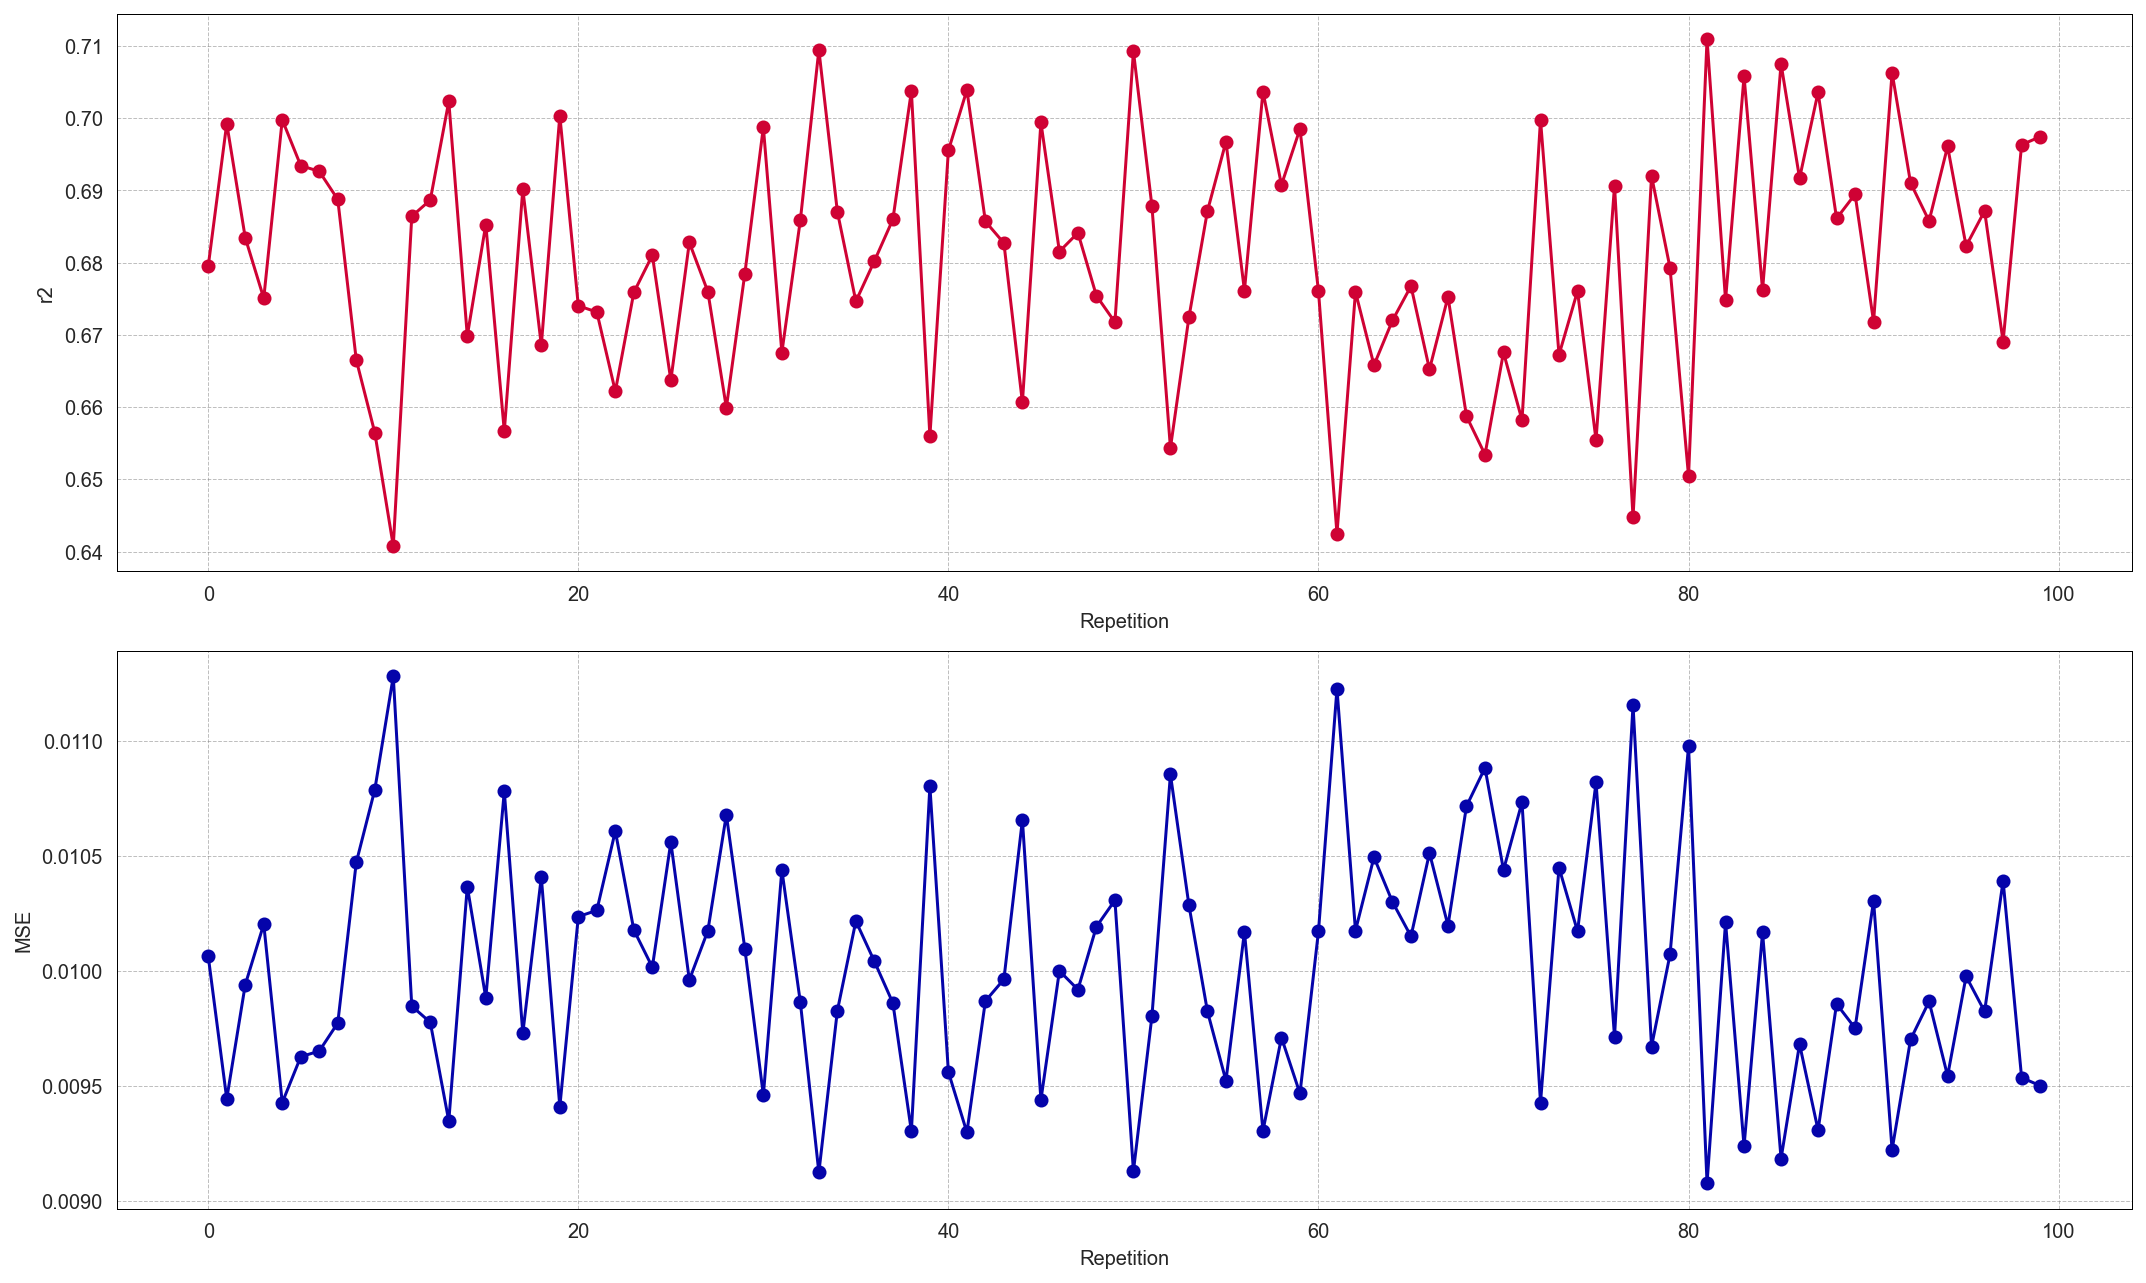

In [12]:
r2_scores, mse_scores = perform_repeated_cv(X, Y, XGB)

# plot results from the 100 repetitions
fig, axes = plt.subplots(2, 1)

axes[0].plot(r2_scores, color="xkcd:cherry", marker="o")
axes[0].set_xlabel("Repetition")
axes[0].set_ylabel("r2")
axes[0].set_facecolor((1, 1, 1))
axes[0].spines["left"].set_color("black")
axes[0].spines["right"].set_color("black")
axes[0].spines["top"].set_color("black")
axes[0].spines["bottom"].set_color("black")
axes[0].spines["left"].set_linewidth(0.5)
axes[0].spines["right"].set_linewidth(0.5)
axes[0].spines["top"].set_linewidth(0.5)
axes[0].spines["bottom"].set_linewidth(0.5)
axes[0].grid(linestyle="--", linewidth="0.5", color="grey", alpha=0.5)

axes[1].plot(mse_scores, color="xkcd:royal blue", marker="o")
axes[1].set_xlabel("Repetition")
axes[1].set_ylabel("MSE")
axes[1].set_facecolor((1, 1, 1))
axes[1].spines["left"].set_color("black")
axes[1].spines["right"].set_color("black")
axes[1].spines["top"].set_color("black")
axes[1].spines["bottom"].set_color("black")
axes[1].spines["left"].set_linewidth(0.5)
axes[1].spines["right"].set_linewidth(0.5)
axes[1].spines["top"].set_linewidth(0.5)
axes[1].spines["bottom"].set_linewidth(0.5)
axes[1].grid(linestyle="--", linewidth="0.5", color="grey", alpha=0.5)


plt.grid(True)
plt.tight_layout()

### Training Data Prediction Visualization:

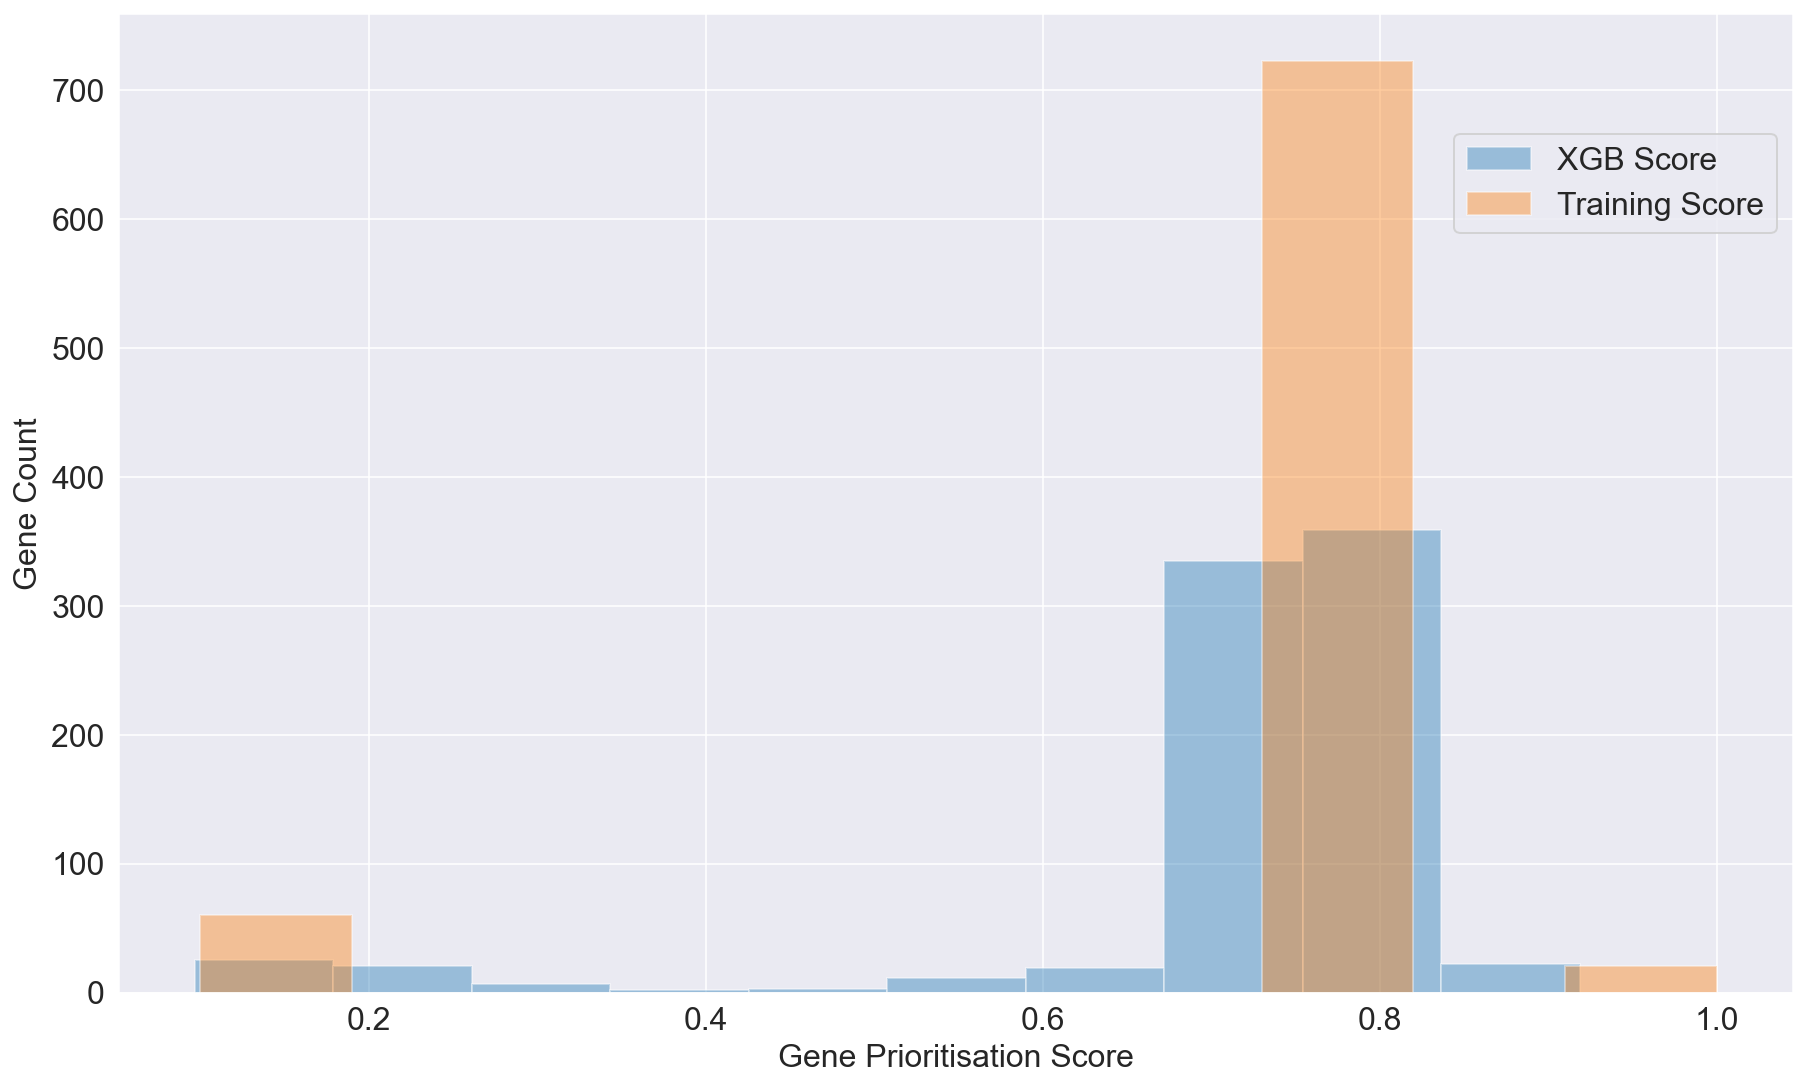

In [15]:
predictions = list(XGB.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

df_total_training = pd.concat([X, output], axis=1)

df_total = pd.concat([X, output], axis=1)

fig, ax = plt.subplots()

sns.distplot(df_total["XGB_Score"], ax=ax, kde=False, norm_hist=False, bins=10)
sns.distplot(Y, ax=ax, kde=False, bins=10)
fig.legend(
    labels=["XGB Score", "Training Score"],
    loc="upper right",
    bbox_to_anchor=(0.9, 0.8),
    ncol=1,
    fontsize=16,
)
ax.set_xlabel("Gene Prioritisation Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

In [16]:
predictions = list(XGB.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

output

Gene  XGB_Score
0      ABCA1   0.903607
1     ABCA12   0.653414
2      ABCA2   0.696213
3      ABCA3   0.765888
4      ABCA7   0.739877
..       ...        ...
799    ZFP91   0.685715
800  ZFYVE28   0.761151
801    ZNF32   0.734938
802   ZNF664   0.733603
803   ZNF781   0.755808

[804 rows x 2 columns]

In [17]:
print(data[["Gene", "label_encoded"]])

df_b = data[["label_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c

        Gene  label_encoded
0      ABCA1           1.00
1     ABCA12           0.75
2      ABCA2           0.75
3      ABCA3           0.75
4      ABCA7           0.75
..       ...            ...
799    ZFP91           0.75
800  ZFYVE28           0.75
801    ZNF32           0.75
802   ZNF664           0.75
803   ZNF781           0.75

[804 rows x 2 columns]


Gene  XGB_Score  label_encoded
0      ABCA1   0.903607           1.00
1     ABCA12   0.653414           0.75
2      ABCA2   0.696213           0.75
3      ABCA3   0.765888           0.75
4      ABCA7   0.739877           0.75
..       ...        ...            ...
799    ZFP91   0.685715           0.75
800  ZFYVE28   0.761151           0.75
801    ZNF32   0.734938           0.75
802   ZNF664   0.733603           0.75
803   ZNF781   0.755808           0.75

[804 rows x 3 columns]

### SHAP Feature Importance Visualization:

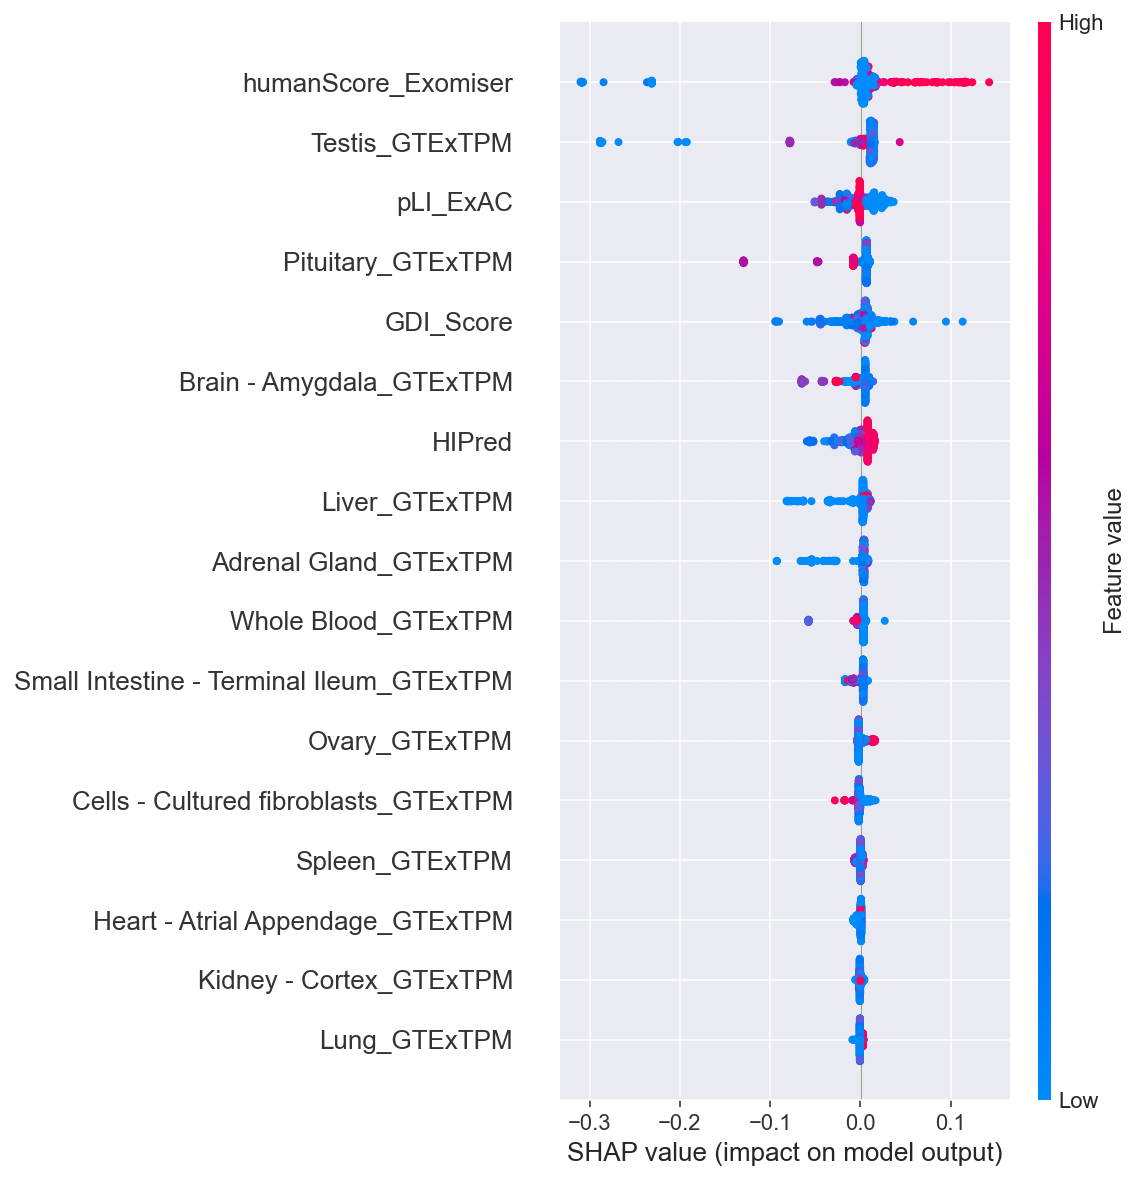

In [16]:
XGB.fit(X, Y)
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

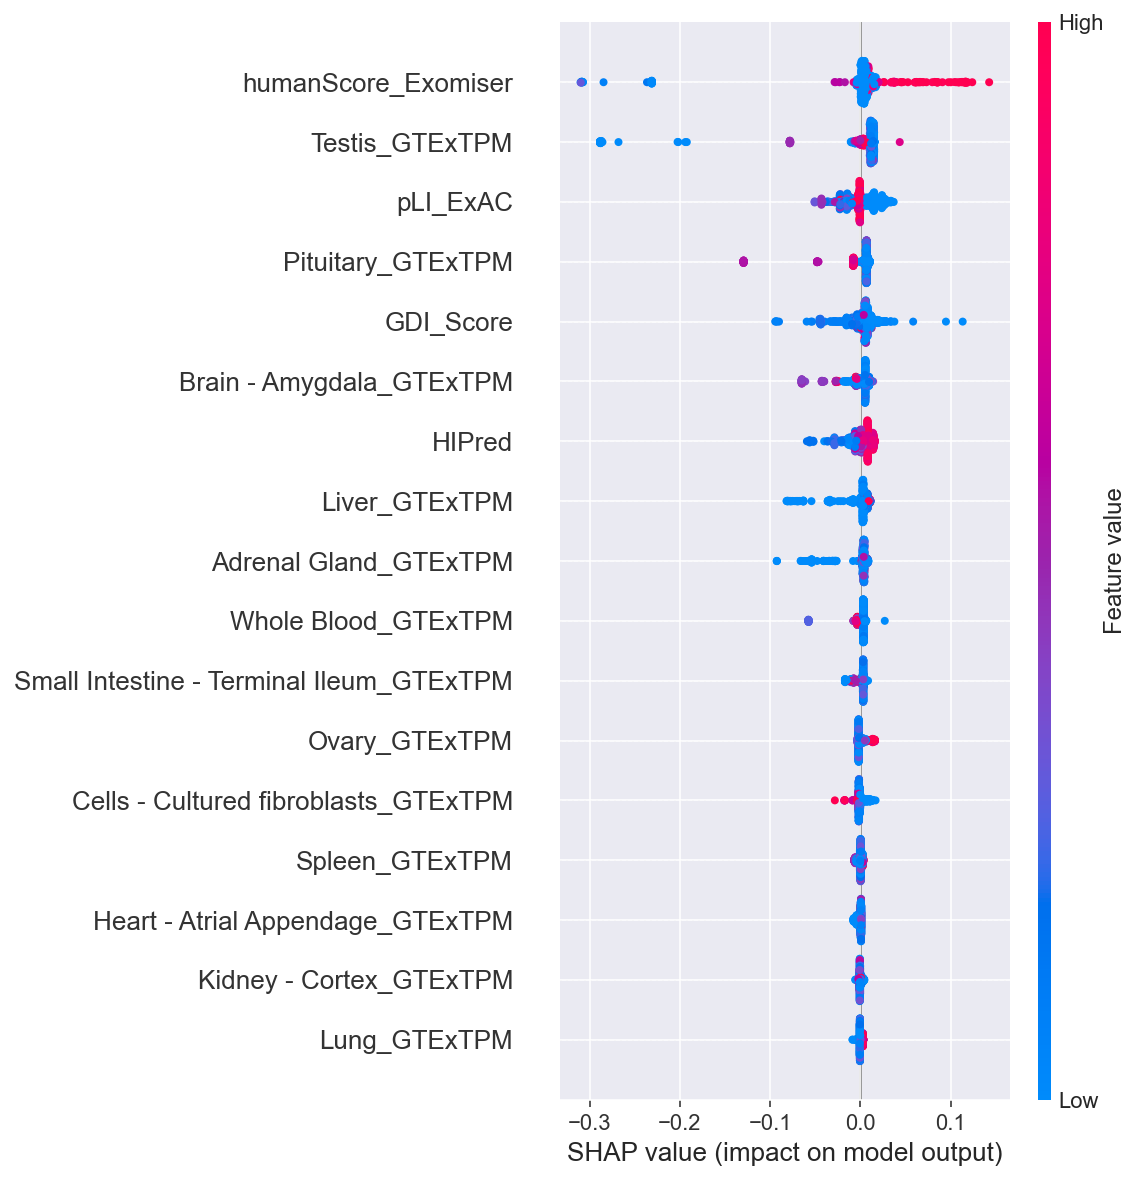

In [17]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X)
fig.savefig("shap_summary.png", format="png", dpi=300, bbox_inches="tight")

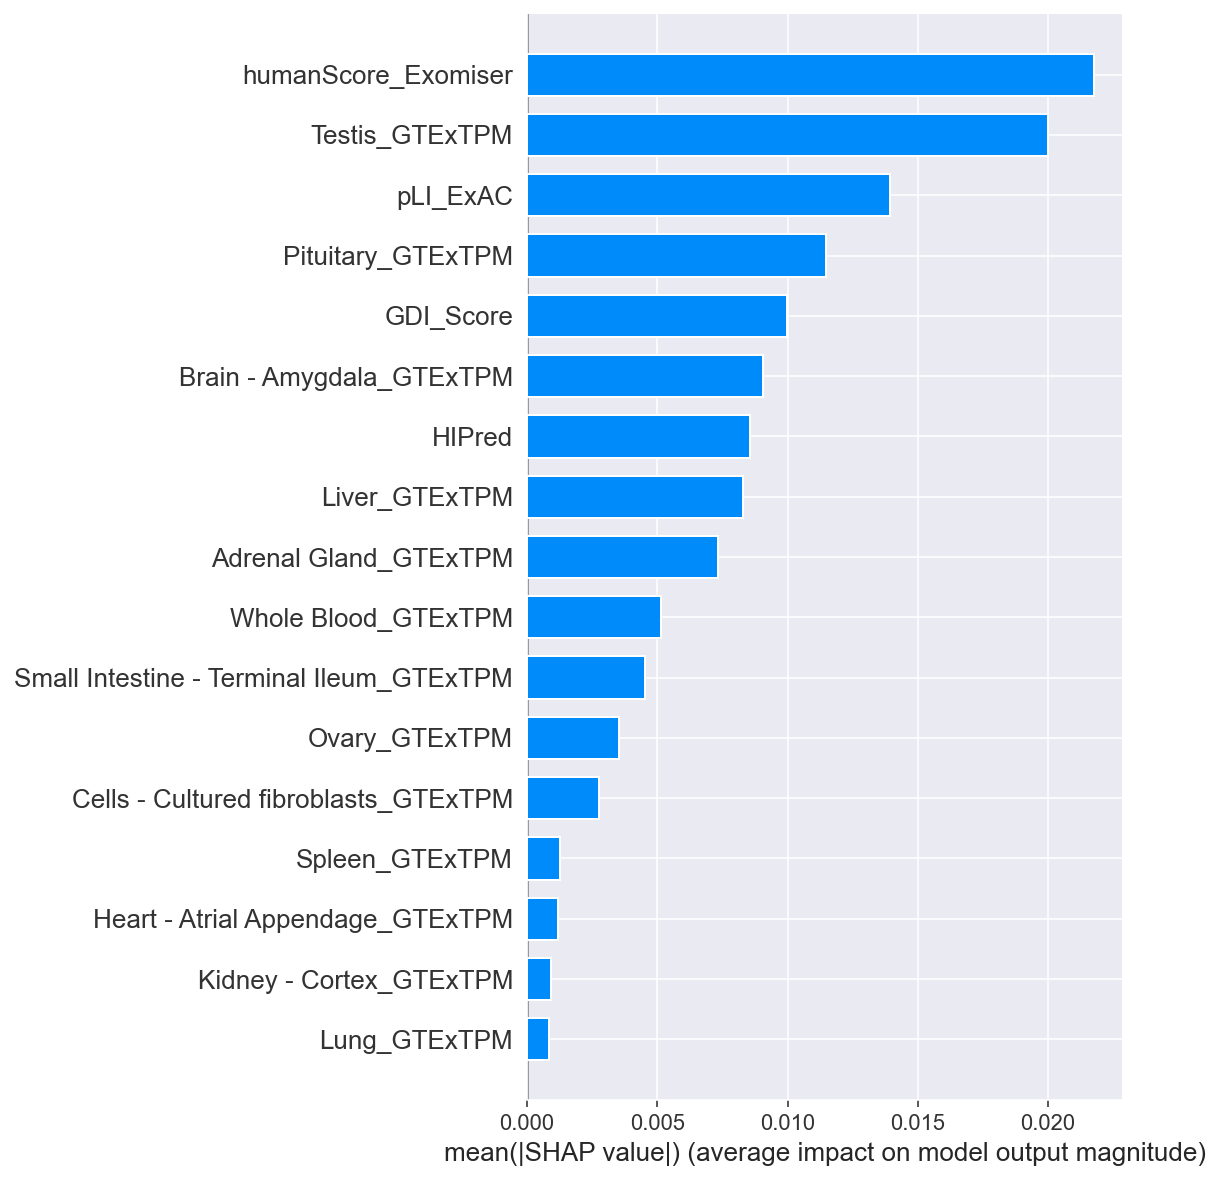

In [18]:
shap.summary_plot(shap_values, X, plot_type="bar")

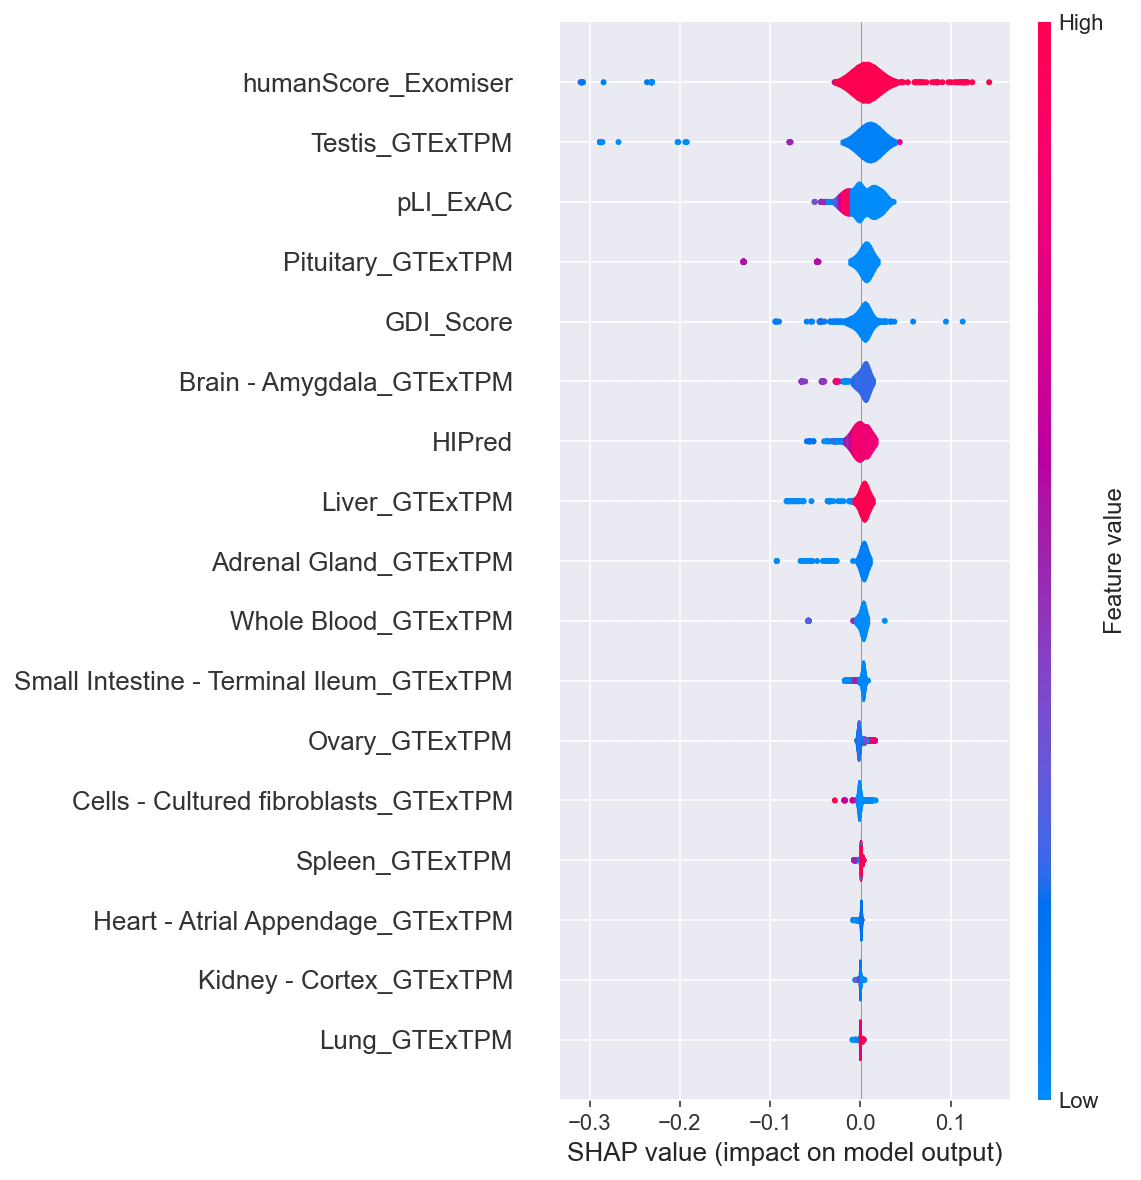

In [19]:
shap.summary_plot(shap_values, X, plot_type="violin", color="coolwarm")

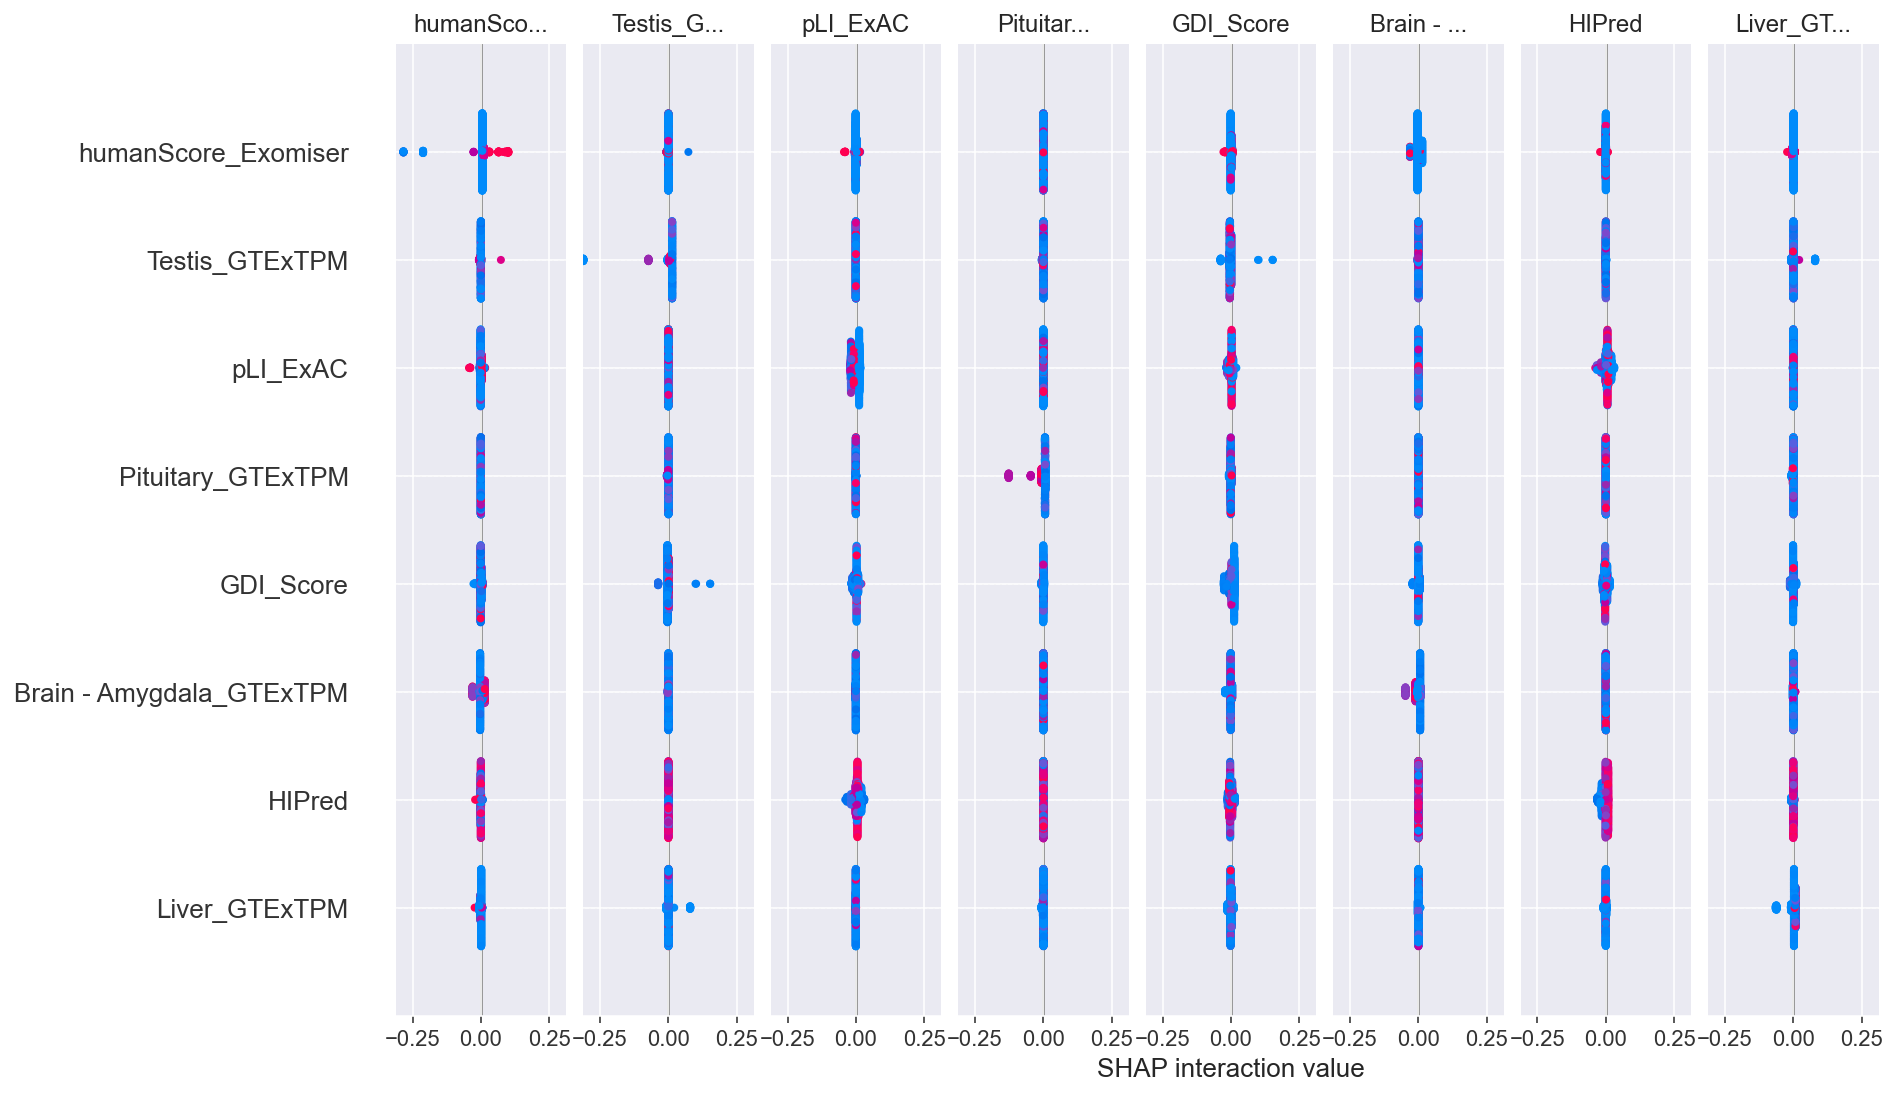

In [20]:
X_interaction = X
shap_interaction_values = shap.TreeExplainer(XGB).shap_interaction_values(X_interaction)
X_interaction2 = pd.DataFrame(data=X_interaction, columns=X.columns)
shap.summary_plot(shap_interaction_values, X_interaction2, max_display=8)

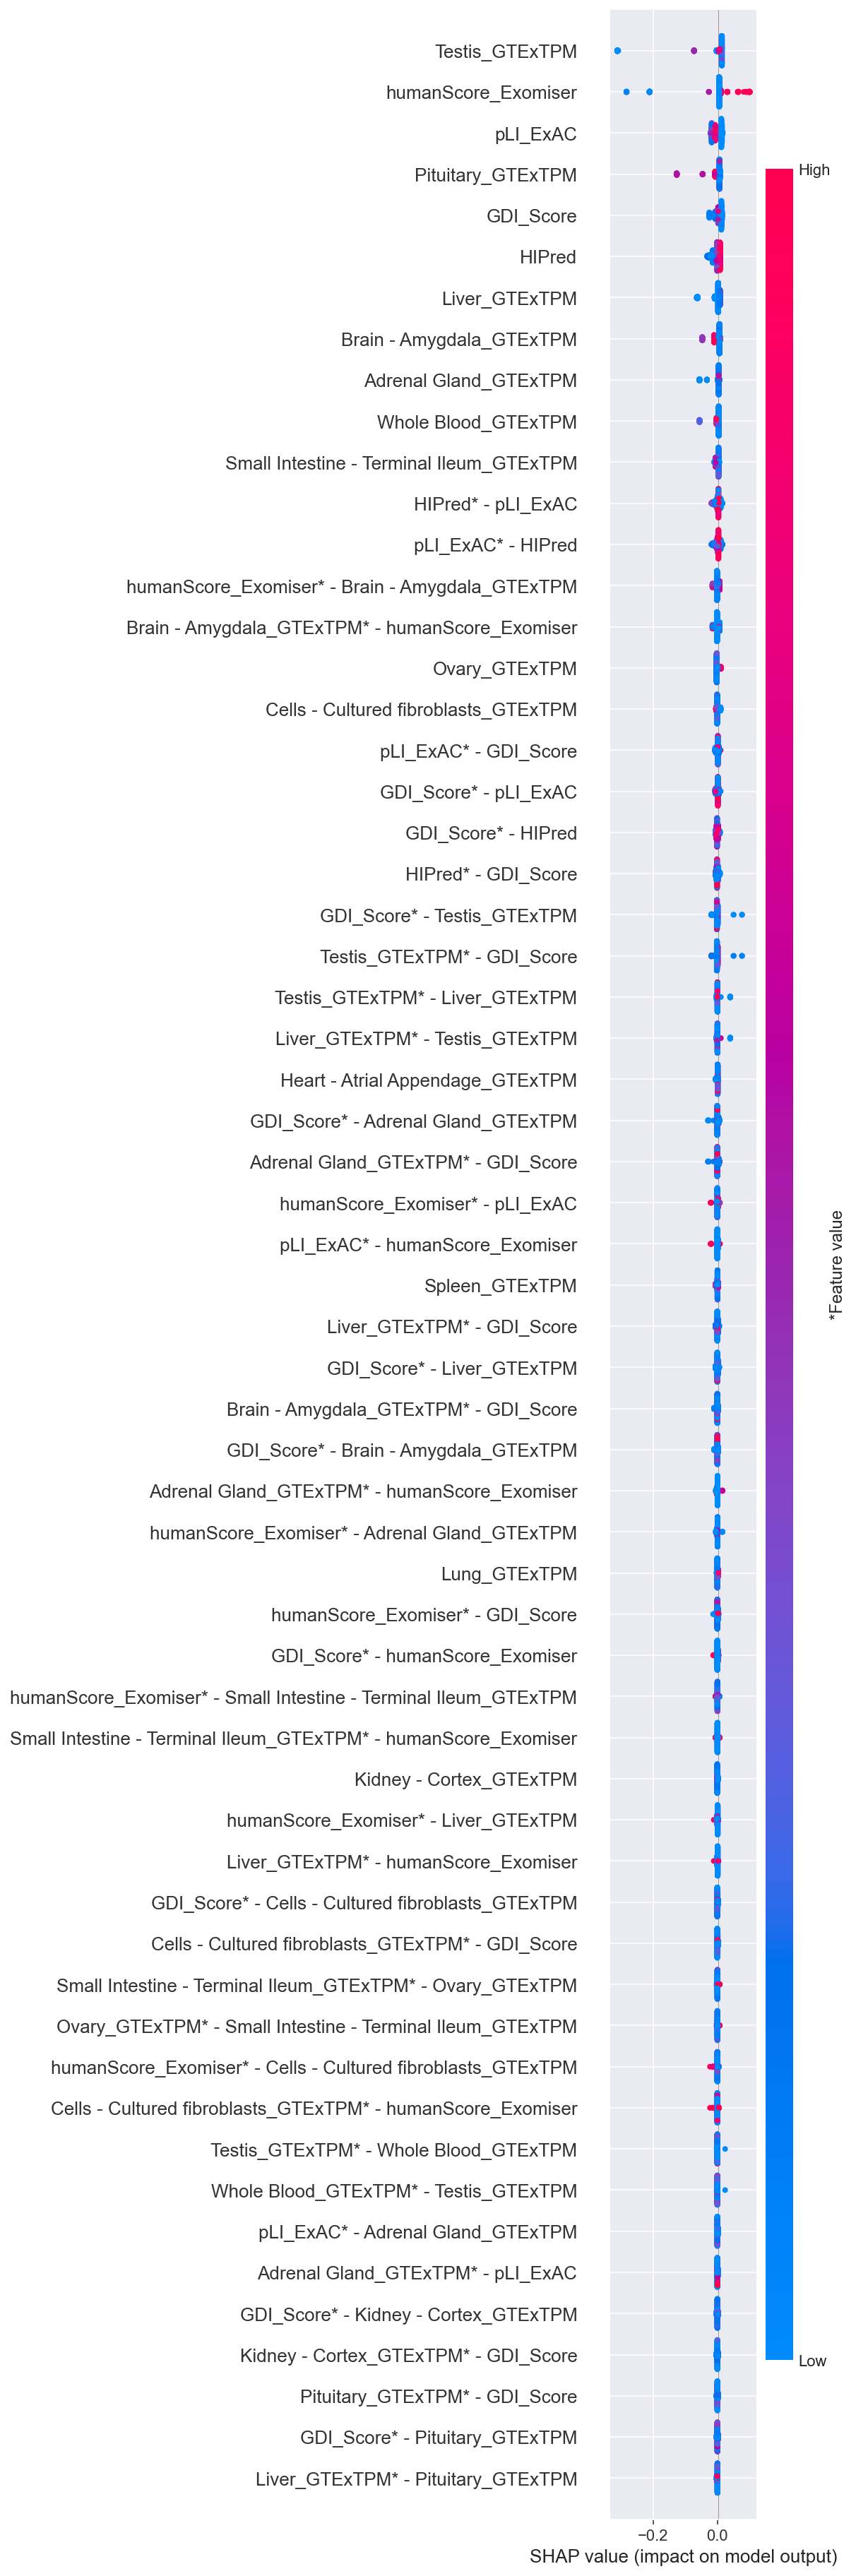

In [21]:
shap.summary_plot(
    shap_interaction_values, X_interaction2, max_display=60, plot_type="compact_dot"
)

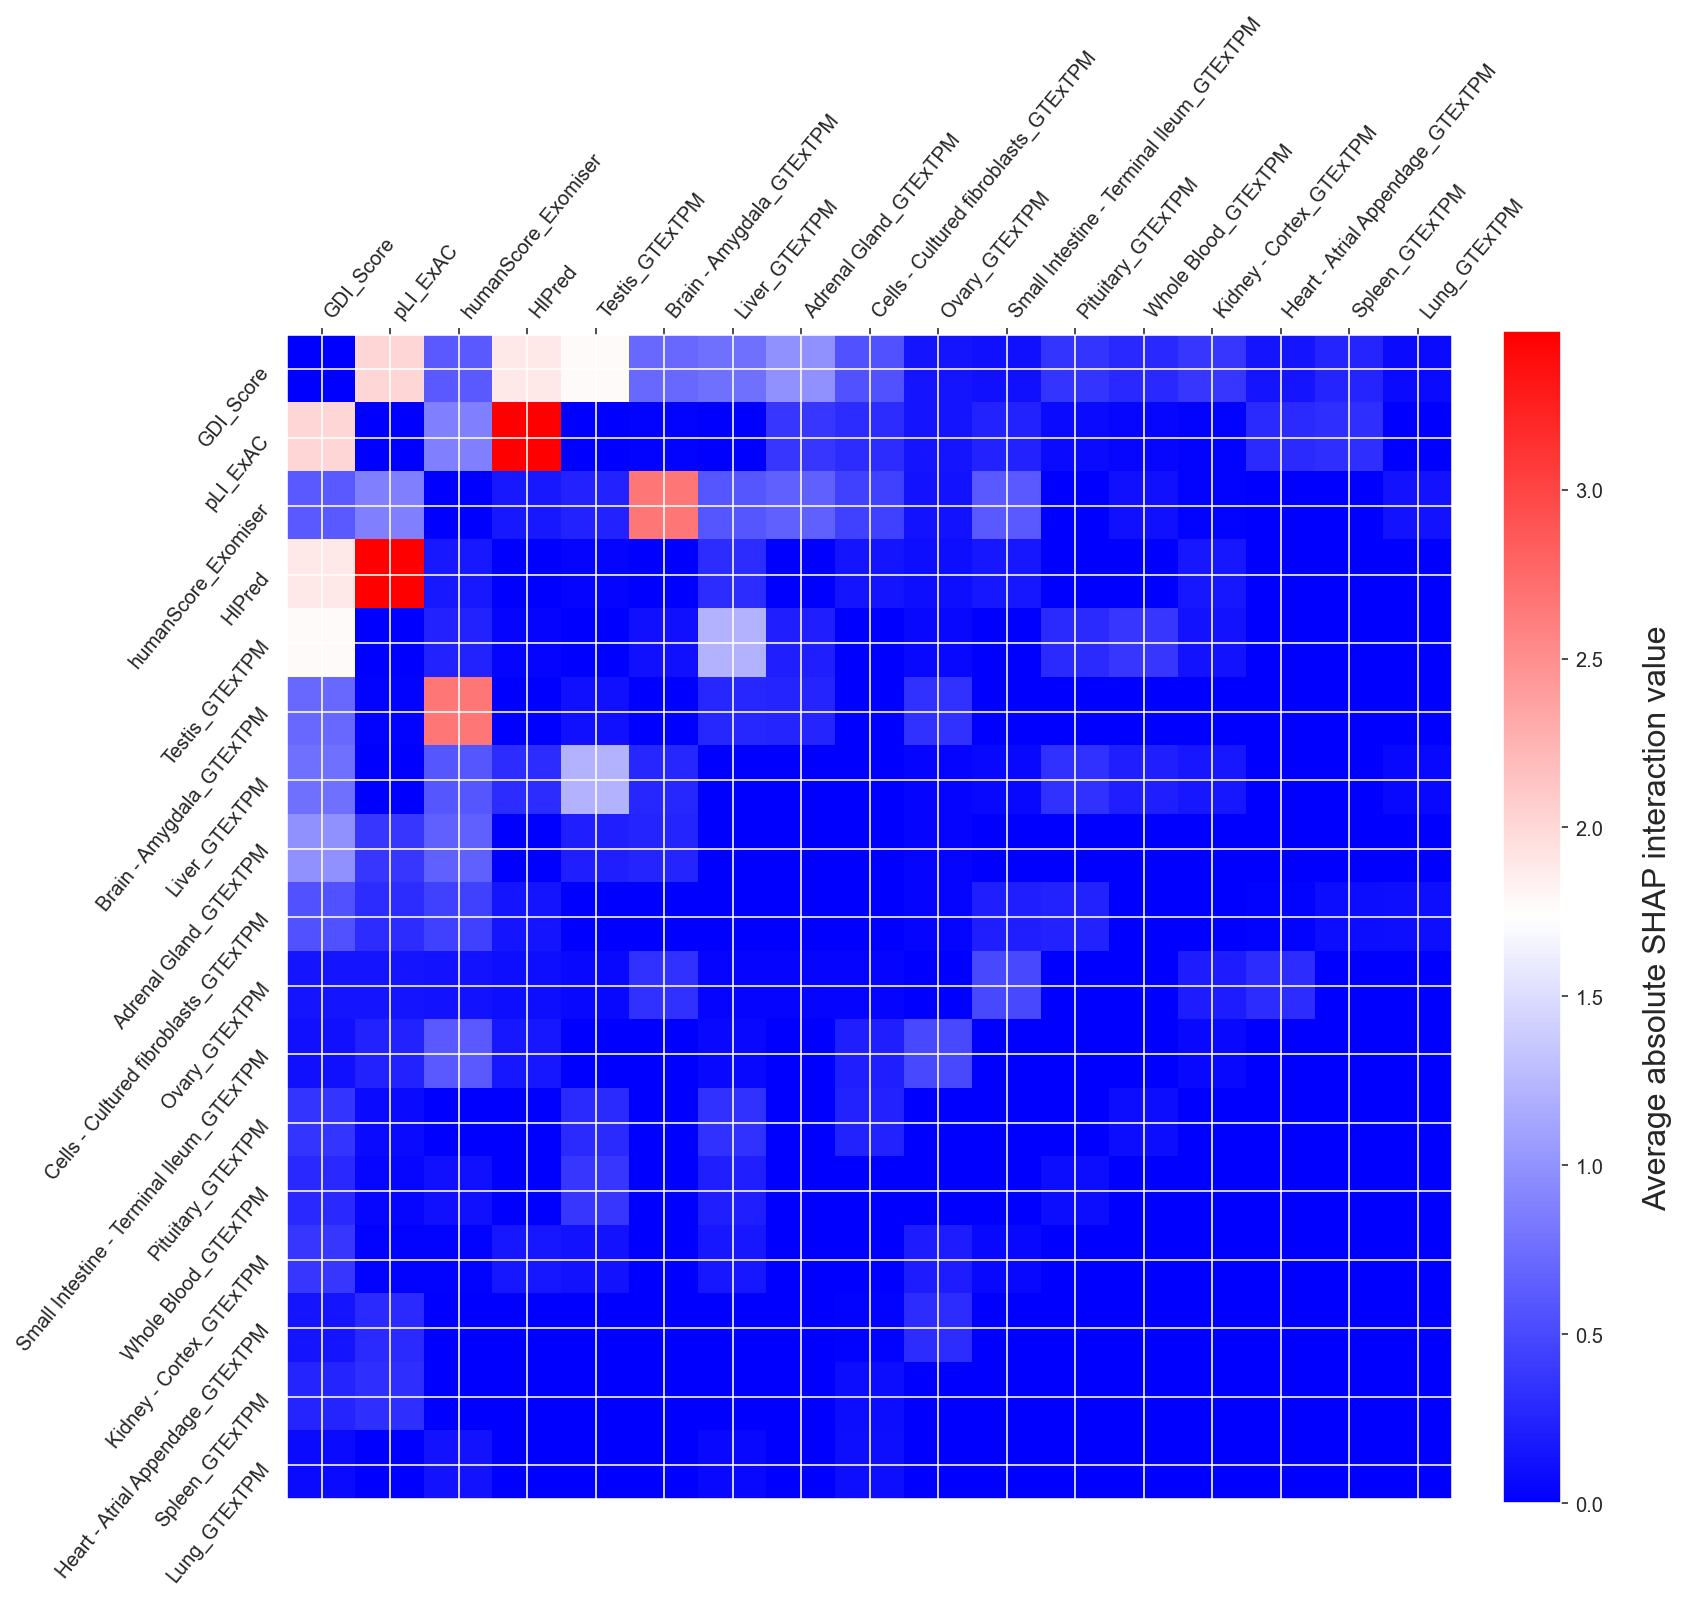

In [22]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]


f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.yticks(
    range(tmp2.shape[0]),
    X_interaction.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    X_interaction.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
f.savefig("shap_interactions.png", format="png", dpi=300)


# plt.show()

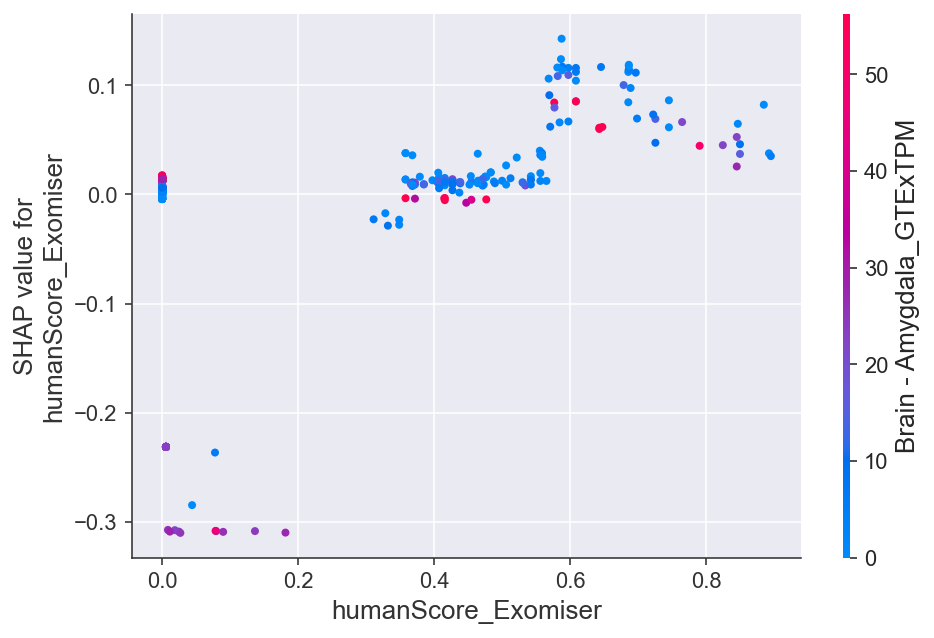

In [23]:
shap.dependence_plot(
    'humanScore_Exomiser', shap_values, X, interaction_index='Brain - Amygdala_GTExTPM'
)

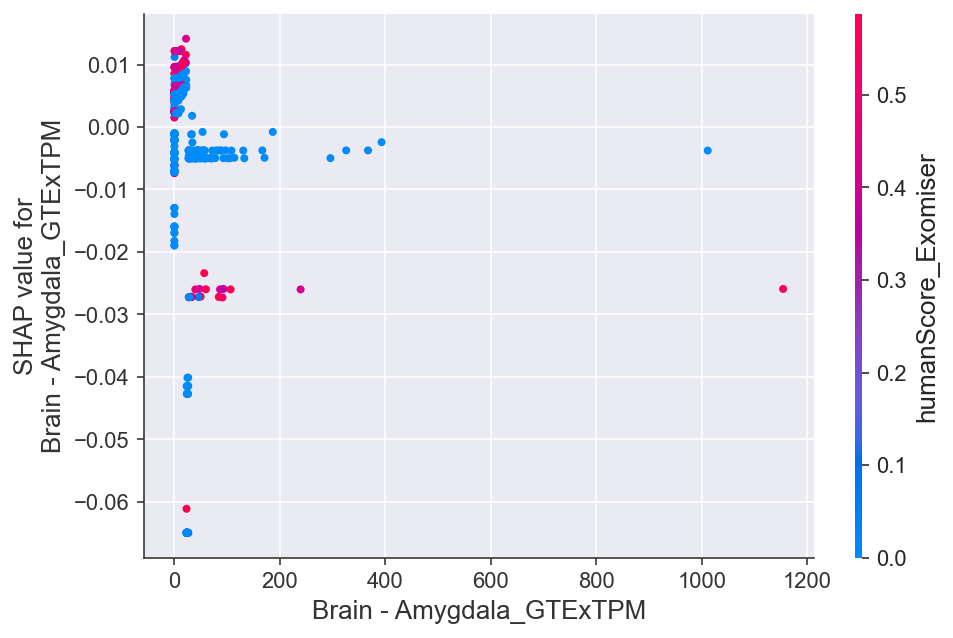

In [24]:
shap.dependence_plot(
    'Brain - Amygdala_GTExTPM', shap_values, X, interaction_index='humanScore_Exomiser'
)

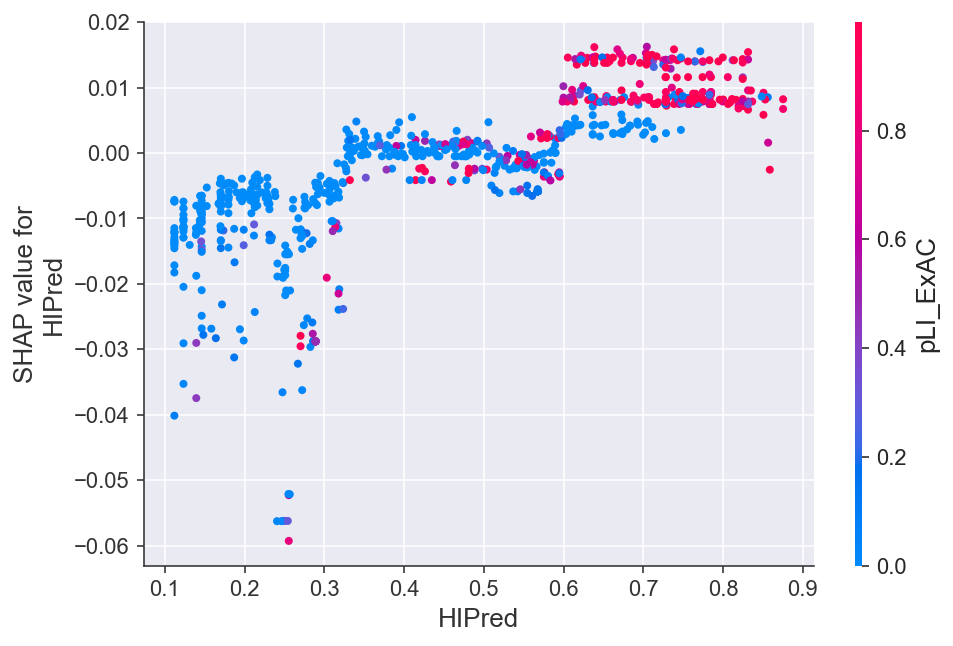

In [27]:
shap.dependence_plot("HIPred", shap_values, X, interaction_index="pLI_ExAC")

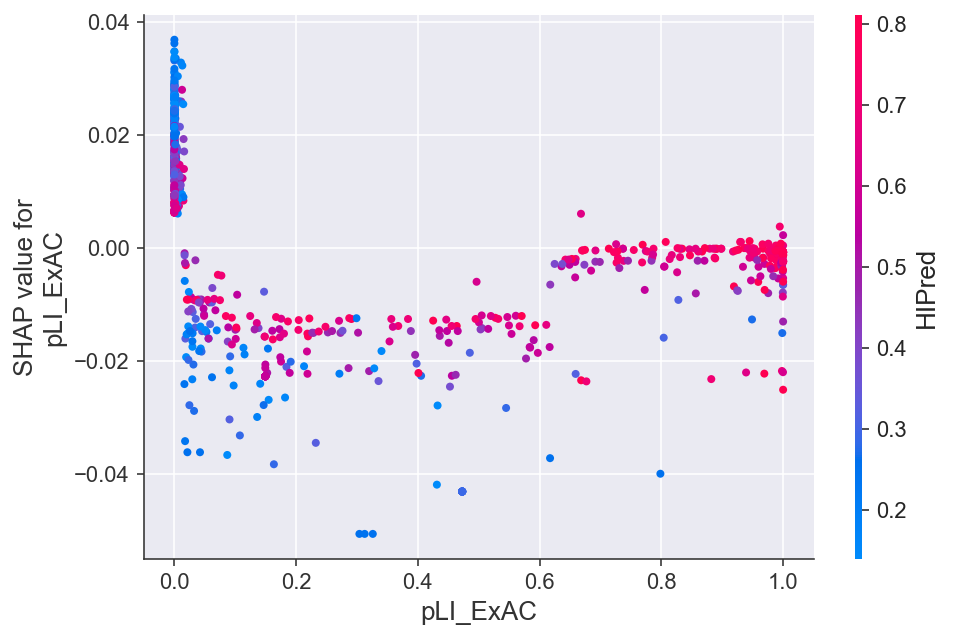

In [25]:
shap.dependence_plot("pLI_ExAC", shap_values, X, interaction_index="HIPred")

In [28]:
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(8)
features = X_test.iloc[select]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: 0.7077952027320862


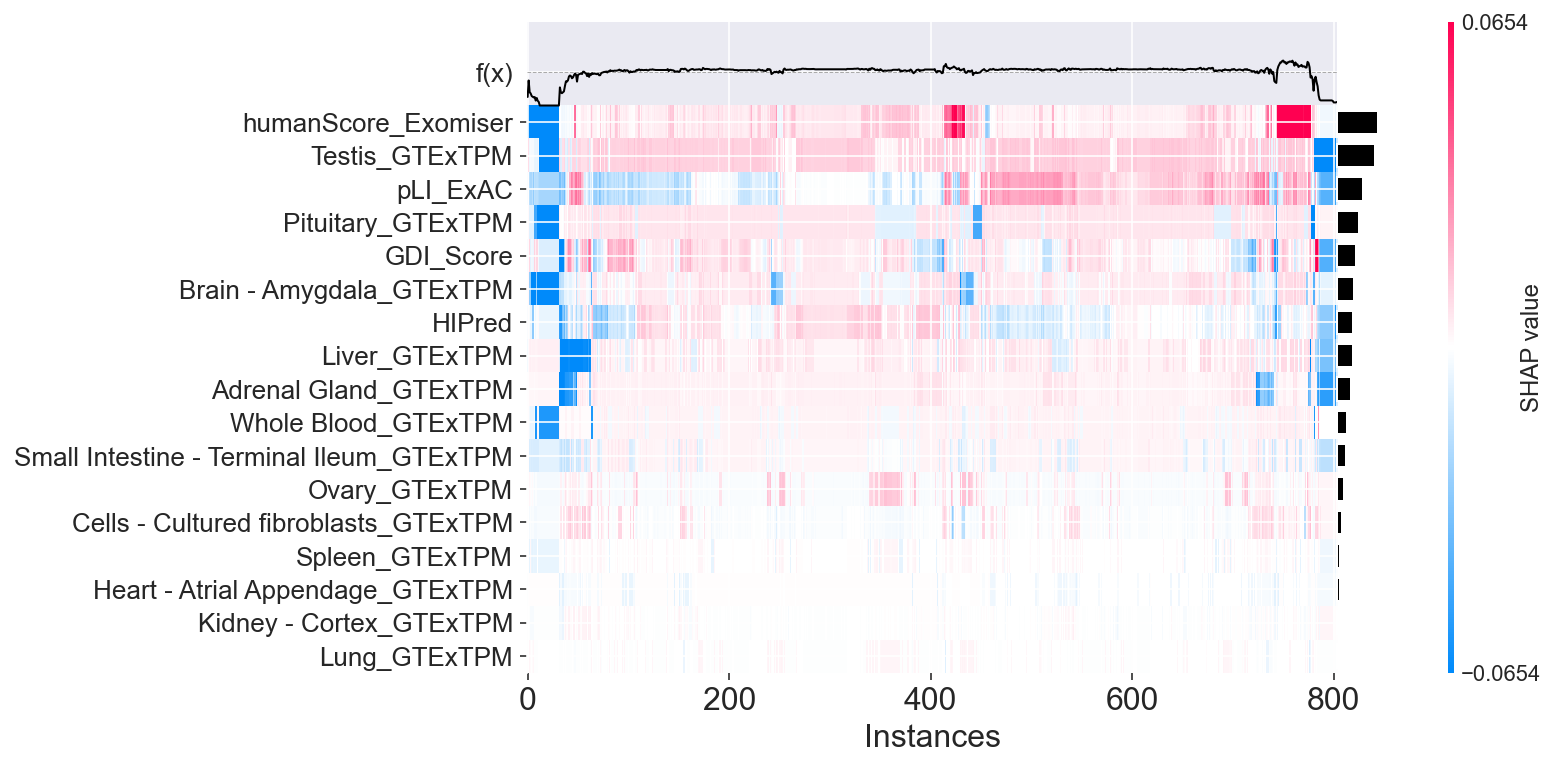

In [39]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html

shap_values = explainer(X)

fig, ax = plt.subplots()
plt.tight_layout()
shap.plots.heatmap(shap_values,max_display=17,show=False)
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(100)
plt.gcf().set_size_inches(8, 5)
fig.savefig("shap_heatmap.png", format="png", dpi=300, bbox_inches="tight")

In [35]:
select = range(17)
features = X.iloc[select]
features_display = X.loc[features.index]
shap_values = explainer.shap_values(X)

In [36]:
#shap.initjs()
#shap.force_plot(
#    explainer.expected_value, shap_values[:821, :], X.iloc[:821, :], features_display,)

In [37]:
#output_of_force_plot = shap.force_plot(
#    explainer.expected_value,
#    shap_values[:821, :],
#    X.iloc[:821, :],
#    features_display,
#    show=False,
#)
#file = "force_plot.html"
#shap.save_html(file, output_of_force_plot)

### SHAP average measures per gene and per feature:

In [38]:
explainer = shap.Explainer(XGB, X)
shap_values2 = explainer.shap_values(X)
features = X.columns.values.tolist()

shapdf = pd.DataFrame(data=np.array(shap_values2), columns=features)
shapdf["shap_average"] = shapdf.mean(axis=1)
shapdf

Cells - Cultured fibroblasts_GTExTPM  Heart - Atrial Appendage_GTExTPM  \
0                                0.000219                          0.000856   
1                               -0.000126                         -0.002560   
2                               -0.000604                          0.001513   
3                                0.000863                          0.000517   
4                               -0.000590                          0.000856   
..                                    ...                               ...   
799                             -0.001615                          0.001429   
800                             -0.000604                          0.001513   
801                             -0.003059                          0.001091   
802                             -0.001932                          0.000772   
803                             -0.000754                          0.000856   

     Adrenal Gland_GTExTPM  Testis_GTExTPM  humanScore_Exomiser  pLI_ExAC  \
0                 0.001624        0.010257             0.104271  0.015203   
1                -0.027615        0.007335            -0.007795  0.017943   
2                 0.001665        0.007655            -0.013945 -0.009862   
3                 0.002735        0.008405            -0.004033  0.005662   
4                 0.002796        0.009541            -0.003411  0.020879   
..                     ...             ...                  ...       ...   
799               0.003055        0.000455             0.004861 -0.010585   
800               0.003727        0.008612            -0.002002 -0.006649   
801               0.003238        0.007909             0.005595 -0.016333   
802               0.003026        0.008117             0.002222  0.013682   
803               0.007047        0.009109            -0.004741  0.025470   

     GDI_Score  Lung_GTExTPM    HIPred  Whole Blood_GTExTPM  Ovary_GTExTPM  \
0     0.011280      0.000563  0.005054             0.005267      -0.001144   
1     0.010152     -0.001040  0.002123             0.002984       0.004824   
2    -0.000053      0.000181  0.017789            -0.003542      -0.001756   
3     0.006174      0.002958  0.003042             0.003615      -0.002347   
4     0.000127     -0.000085 -0.008824            -0.004056      -0.001792   
..         ...           ...       ...                  ...            ...   
799  -0.001045     -0.000181 -0.000085             0.004073      -0.002632   
800  -0.001630     -0.000238  0.017690             0.003837      -0.002022   
801   0.009483     -0.000286  0.002616             0.003649       0.013825   
802  -0.000240     -0.000181  0.000300             0.003803      -0.002931   
803  -0.015555     -0.000319 -0.011113             0.003365      -0.002056   

     Spleen_GTExTPM  Kidney - Cortex_GTExTPM  Pituitary_GTExTPM  \
0         -0.000231                 0.000019           0.005968   
1          0.002485                 0.004316           0.003416   
2          0.000263                -0.000264          -0.009164   
3         -0.000088                -0.000485           0.005597   
4          0.000930                 0.000104          -0.009393   
..              ...                      ...                ...   
799        0.000263                 0.001401           0.005838   
800        0.000263                -0.000491           0.005973   
801       -0.006462                -0.000587          -0.009445   
802       -0.000400                -0.000587          -0.009259   
803       -0.000088                 0.000700           0.006816   

     Small Intestine - Terminal Ileum_GTExTPM  Liver_GTExTPM  \
0                                    0.003269       0.008943   
1                                   -0.010099      -0.073188   
2                                    0.002543       0.007681   
3                                    0.002819       0.000687   
4                                    0.003206       0.000886   
..   

In [39]:
df_d = pd.concat([df_c, shapdf], axis=1)
df_d.to_csv("training_features_shapavg.csv", index=False)
df_d

Gene  XGB_Score  label_encoded  Cells - Cultured fibroblasts_GTExTPM  \
0      ABCA1   0.896054           1.00                              0.000219   
1     ABCA12   0.673150           0.75                             -0.000126   
2      ABCA2   0.697967           0.75                             -0.000604   
3      ABCA3   0.768923           0.75                              0.000863   
4      ABCA7   0.743153           0.75                             -0.000590   
..       ...        ...            ...                                   ...   
799    ZFP91   0.542704           0.75                             -0.001615   
800  ZFYVE28   0.754857           0.75                             -0.000604   
801    ZNF32   0.727548           0.75                             -0.003059   
802   ZNF664   0.730293           0.75                             -0.001932   
803   ZNF781   0.750737           0.75                             -0.000754   

     Heart - Atrial Appendage_GTExTPM  Adrenal Gland_GTExTPM  Testis_GTExTPM  \
0                            0.000856               0.001624        0.010257   
1                           -0.002560              -0.027615        0.007335   
2                            0.001513               0.001665        0.007655   
3                            0.000517               0.002735        0.008405   
4                            0.000856               0.002796        0.009541   
..                                ...                    ...             ...   
799                          0.001429               0.003055        0.000455   
800                          0.001513               0.003727        0.008612   
801                          0.001091               0.003238        0.007909   
802                          0.000772               0.003026        0.008117   
803                          0.000856               0.007047        0.009109   

     humanScore_Exomiser  pLI_ExAC  GDI_Score  ...    HIPred  \
0               0.104271  0.015203   0.011280  ...  0.005054   
1              -0.007795  0.017943   0.010152  ...  0.002123   
2              -0.013945 -0.009862  -0.000053  ...  0.017789   
3              -0.004033  0.005662   0.006174  ...  0.003042   
4              -0.003411  0.020879   0.000127  ... -0.008824   
..                   ...       ...        ...  ...       ...   
799             0.004861 -0.010585  -0.001045  ... -0.000085   
800            -0.002002 -0.006649  -0.001630  ...  0.017690   
801             0.005595 -0.016333   0.009483  ...  0.002616   
802             0.002222  0.013682  -0.000240  ...  0.000300   
803            -0.004741  0.025470  -0.015555  ... -0.011113   

     Whole Blood_GTExTPM  Ovary_GTExTPM  Spleen_GTExTPM  \
0               0.005267      -0.001144       -0.000231   
1               0.002984       0.004824        0.002485   
2              -0.003542      -0.001756        0.000263   
3               0.003615      -0.002347       -0.000088   
4              -0.004056      -0.001792        0.000930   
..                   ...            ...             ...   
799             0.004073      -0.002632        0.000263   
800             0.003837      -0.002022        0.000263   
801             0.003649       0.013825       -0.006462   
802             0.003803      -0.002931       -0.000400   
803             0.003365      -0.002056       -0.000088   

     Kidney - Cortex_GTExTPM  Pituitary_GTExTPM  \
0                   0.000019           0.005968   
1                   0.004316           0.003416   
2                  -0.000264          -0.009164   
3                  -0.000485           0.005597   
4                   0.000104          -0.009393   
..                       ...                ...   
799                 0.001401           0.005838   
800                -0.000491           0.005973   
801                -0.000587          -0.009445   
802                -0.000587          -0.009259   
803                 0.000700           0.006816

In [40]:
df_e = df_d[["Gene", "XGB_Score", "shap_average", "label_encoded"]]
df_e.to_csv("training_genes_shapavg.csv", index=False)
df_e

Gene  XGB_Score  shap_average  label_encoded
0      ABCA1   0.896054      0.010500           1.00
1     ABCA12   0.673150     -0.004217           0.75
2      ABCA2   0.697967     -0.001700           0.75
3      ABCA3   0.768923      0.002399           0.75
4      ABCA7   0.743153      0.000869           0.75
..       ...        ...           ...            ...
799    ZFP91   0.542704     -0.002317           0.75
800  ZFYVE28   0.754857      0.002120           0.75
801    ZNF32   0.727548      0.000578           0.75
802   ZNF664   0.730293      0.000500           0.75
803   ZNF781   0.750737      0.001806           0.75

[804 rows x 4 columns]

## Decision Plots:
- The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
- The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. _This is usually different than the importance ordering for the entire dataset._ In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
- Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
- Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
- At the bottom of the plot, the observations converge at explainer.expected_value.

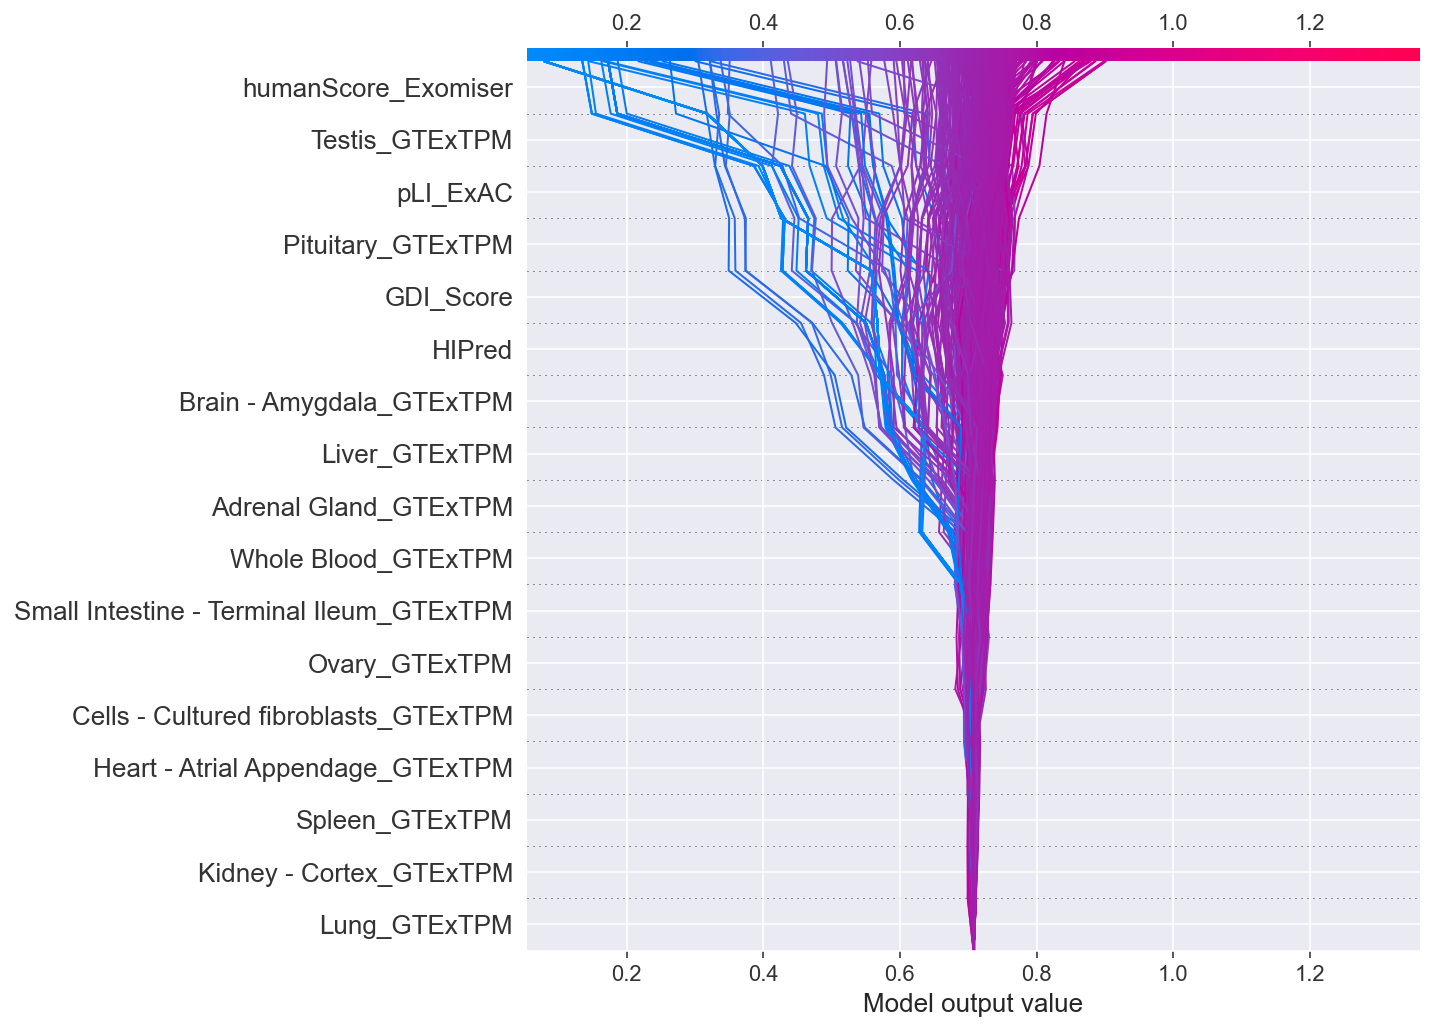

In [41]:
shap.decision_plot(
    expected_value, explainer.shap_values(X), features_display, ignore_warnings=True,
)

In [42]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [43]:
y_pred = XGB.predict(X)

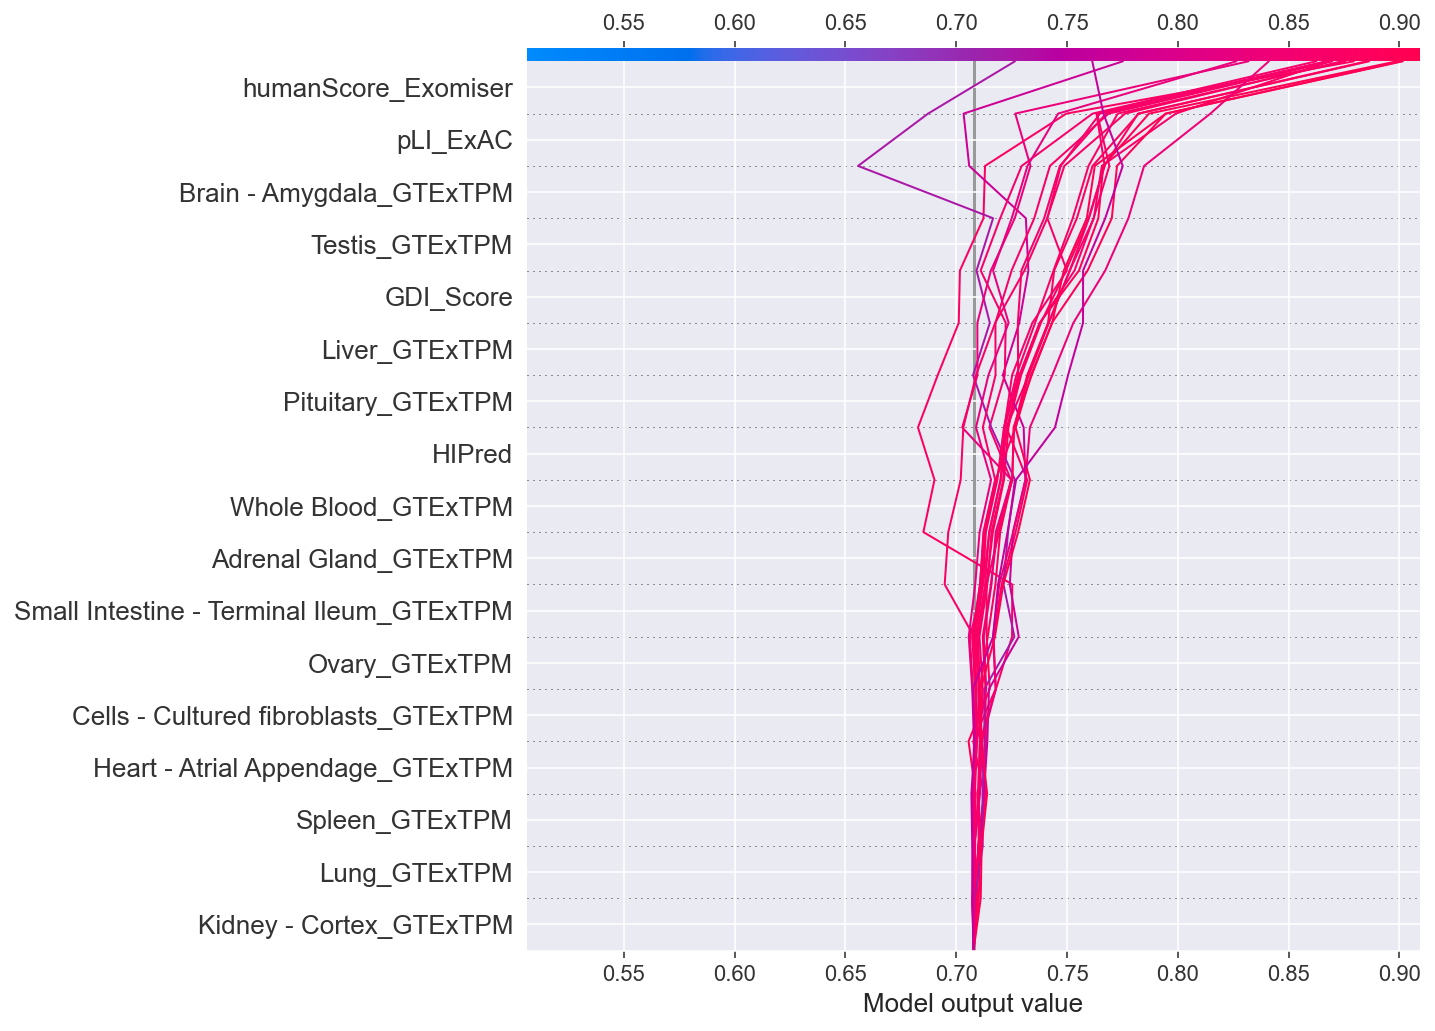

In [44]:
T = X
T = T[(Y == 1)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)

fig, ax = plt.subplots()
shap.decision_plot(expected_value, sh, T, return_objects=True)
fig.savefig("shap_21genes.png", format="png", dpi=300, bbox_inches="tight")

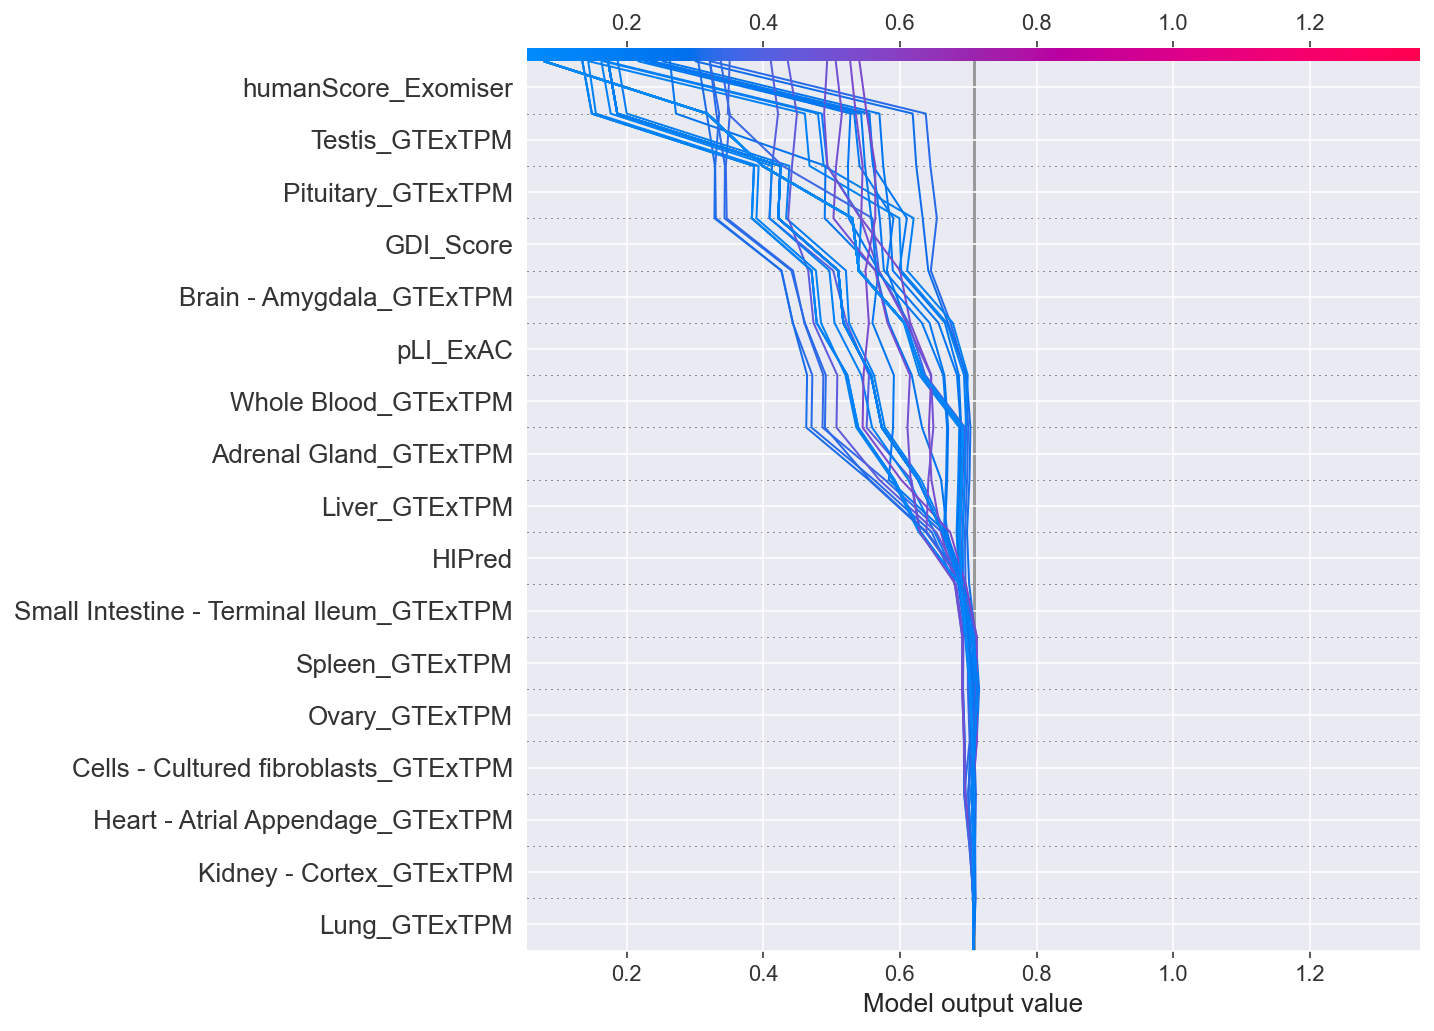

In [45]:
y_pred = XGB.predict(X)
T = X
T = T[(Y == 0.1)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

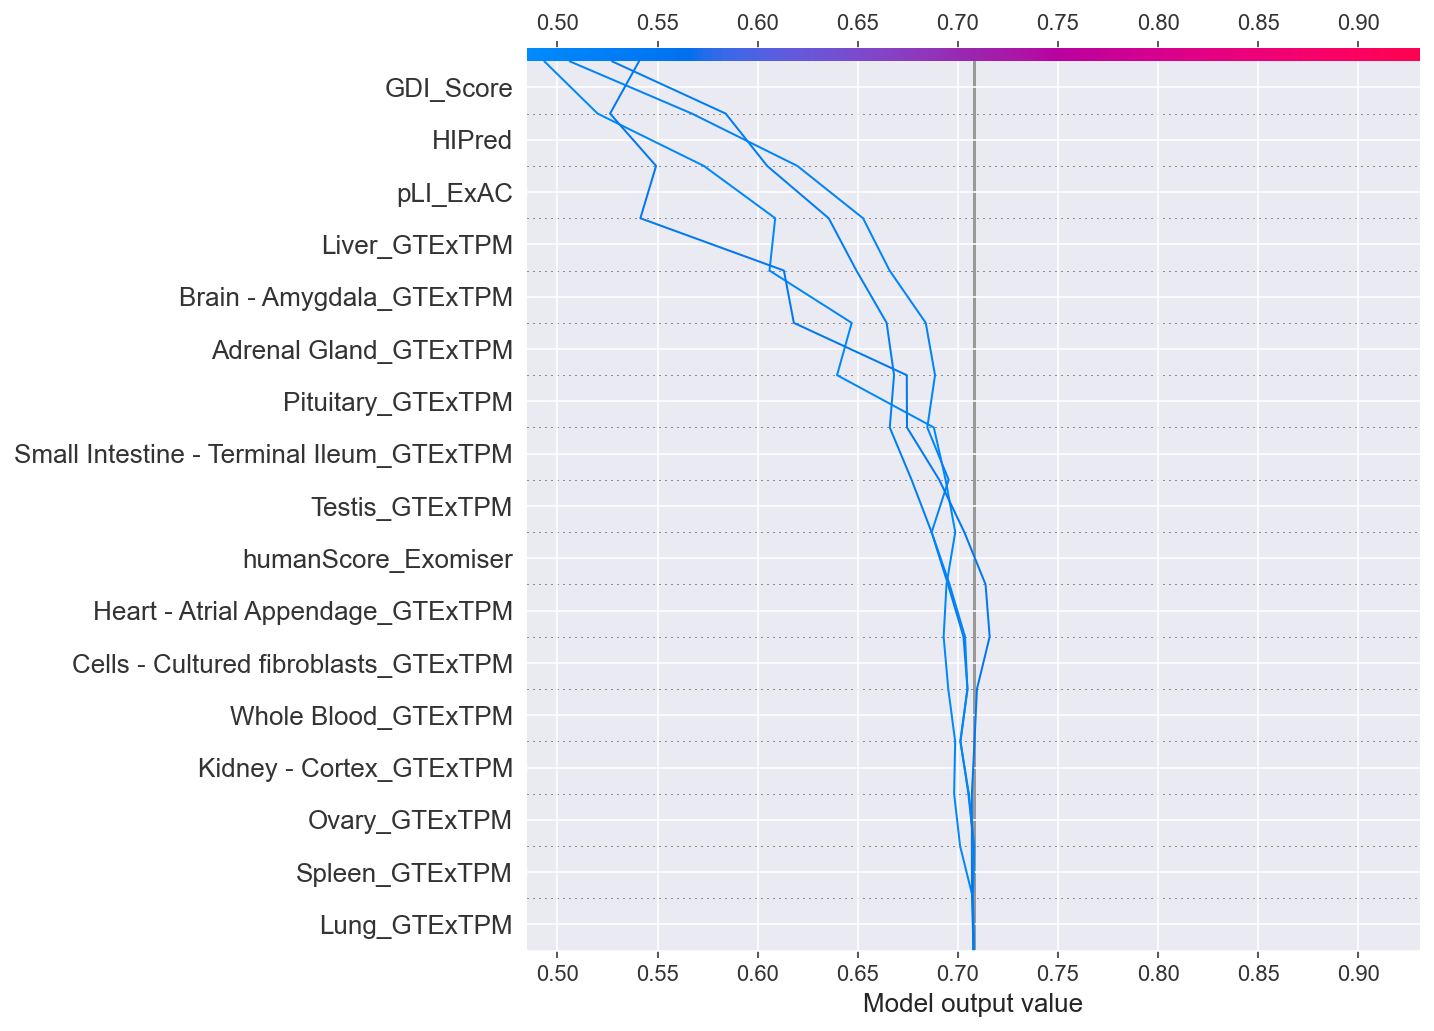

In [47]:
T = X[(y_pred >= 0.5)]
T = T[(Y == 0.1)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [48]:
T

Cells - Cultured fibroblasts_GTExTPM  Heart - Atrial Appendage_GTExTPM  \
586                              0.345388                          0.049911   
593                             41.066005                         23.642626   
697                              0.089995                          0.067869   
709                              0.000000                          0.000000   

     Adrenal Gland_GTExTPM  Testis_GTExTPM  humanScore_Exomiser  pLI_ExAC  \
586               0.117318        0.079760                  0.0  0.090576   
593              39.682633       54.548579                  0.0  0.617147   
697               0.079582        0.664015                  0.0  0.021386   
709               0.000000        0.170426                  0.0  0.004445   

      GDI_Score  Lung_GTExTPM    HIPred  Whole Blood_GTExTPM  Ovary_GTExTPM  \
586  269.318656      0.151437  0.317794             0.053811       0.121857   
593  296.945076     56.304984  0.255355            24.738639      50.781519   
697  248.175910      0.186872  0.255001             0.087861       0.180653   
709   56.139970      0.000000  0.146139             0.000000       0.000000   

     Spleen_GTExTPM  Kidney - Cortex_GTExTPM  Pituitary_GTExTPM  \
586        0.151914                 0.080963           0.091256   
593       51.084733                26.113596          60.345525   
697        0.203874                 0.068864           0.162764   
709        0.000000                 0.000000           0.252898   

     Small Intestine - Terminal Ileum_GTExTPM  Liver_GTExTPM  \
586                                  0.103582       0.068116   
593                                 47.301634      23.384596   
697                                  0.183061       0.042732   
709                                  0.000000       0.000000   

     Brain - Amygdala_GTExTPM  
586                  0.083413  
593                 24.726380  
697                  0.023445  
709                  0.176438

In [50]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

X.iloc[[586,593,697,709]]

Cells - Cultured fibroblasts_GTExTPM  \
Gene                                             
PPIAL4D                               0.345388   
PRAMEF22                             41.066005   
SPDYE2                                0.089995   
STH                                   0.000000   

          Heart - Atrial Appendage_GTExTPM  Adrenal Gland_GTExTPM  \
Gene                                                                
PPIAL4D                           0.049911               0.117318   
PRAMEF22                         23.642626              39.682633   
SPDYE2                            0.067869               0.079582   
STH                               0.000000               0.000000   

          Testis_GTExTPM  humanScore_Exomiser  pLI_ExAC   GDI_Score  \
Gene                                                                  
PPIAL4D         0.079760                  0.0  0.090576  269.318656   
PRAMEF22       54.548579                  0.0  0.617147  296.945076   
SPDYE2          0.664015                  0.0  0.021386  248.175910   
STH             0.170426                  0.0  0.004445   56.139970   

          Lung_GTExTPM    HIPred  Whole Blood_GTExTPM  Ovary_GTExTPM  \
Gene                                                                   
PPIAL4D       0.151437  0.317794             0.053811       0.121857   
PRAMEF22     56.304984  0.255355            24.738639      50.781519   
SPDYE2        0.186872  0.255001             0.087861       0.180653   
STH           0.000000  0.146139             0.000000       0.000000   

          Spleen_GTExTPM  Kidney - Cortex_GTExTPM  Pituitary_GTExTPM  \
Gene                                                                   
PPIAL4D         0.151914                 0.080963           0.091256   
PRAMEF22       51.084733                26.113596          60.345525   
SPDYE2          0.203874                 0.068864           0.162764   
STH             0.000000                 0.000000           0.252898   

          Small Intestine - Terminal Ileum_GTExTPM  Liver_GTExTPM  \
Gene                                                                
PPIAL4D                                   0.103582       0.068116   
PRAMEF22                                 47.301634      23.384596   
SPDYE2                                    0.183061       0.042732   
STH                                       0.000000       0.000000   

          Brain - Amygdala_GTExTPM  
Gene                                
PPIAL4D                   0.083413  
PRAMEF22                 24.726380  
SPDYE2                    0.023445  
STH                       0.176438

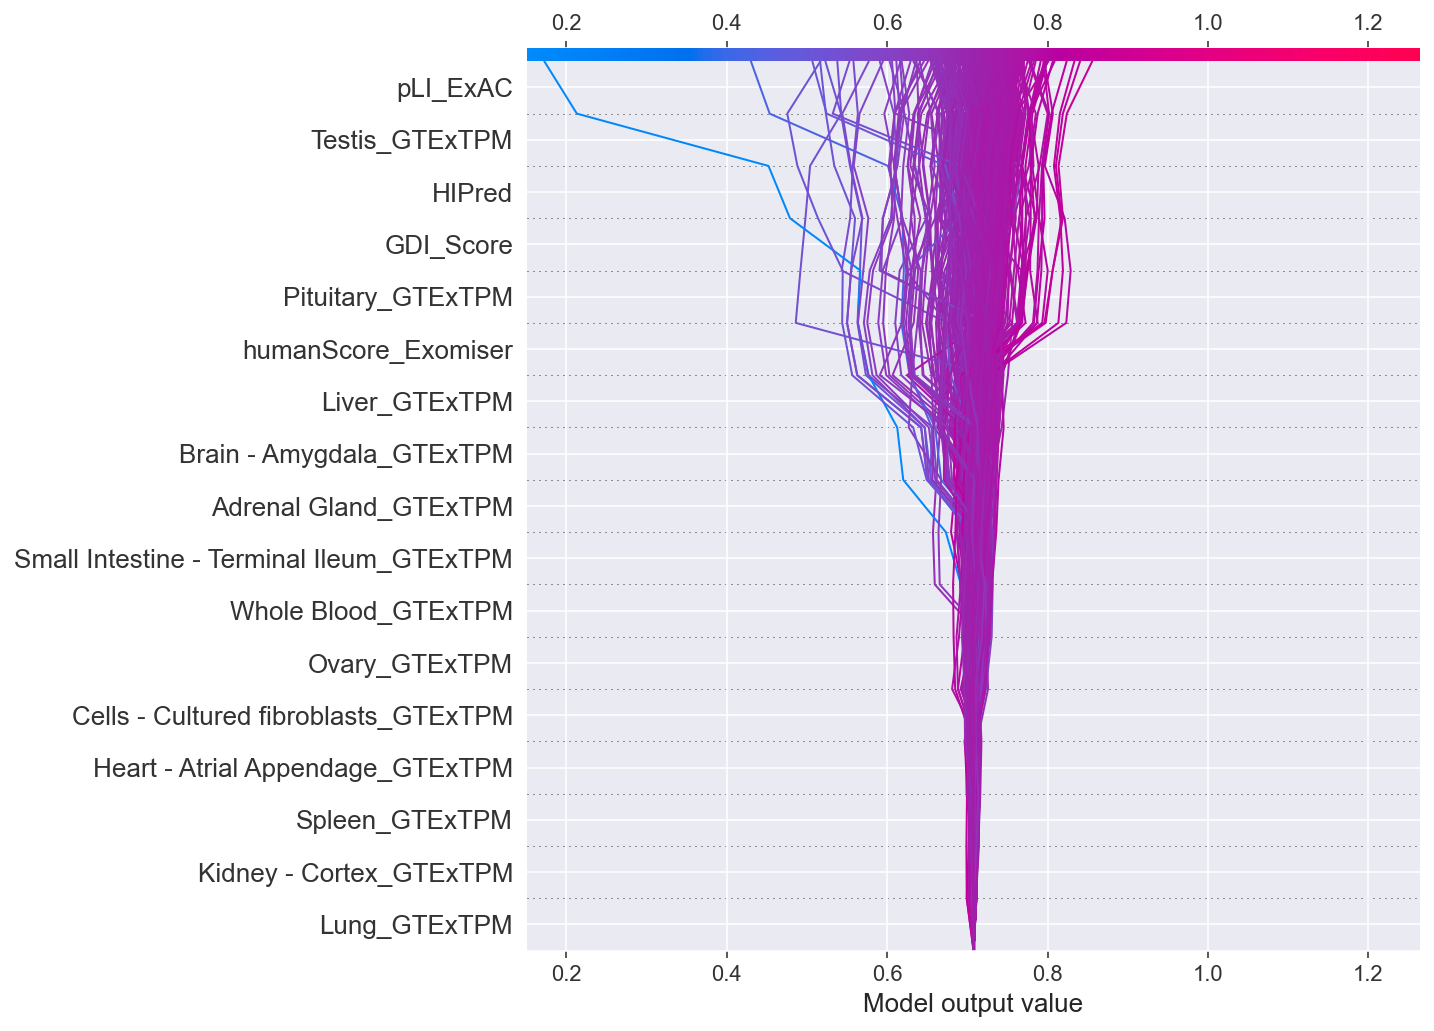

In [51]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
y_pred = XGB.predict(X)
T = X
T = T[(Y == 0.75)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

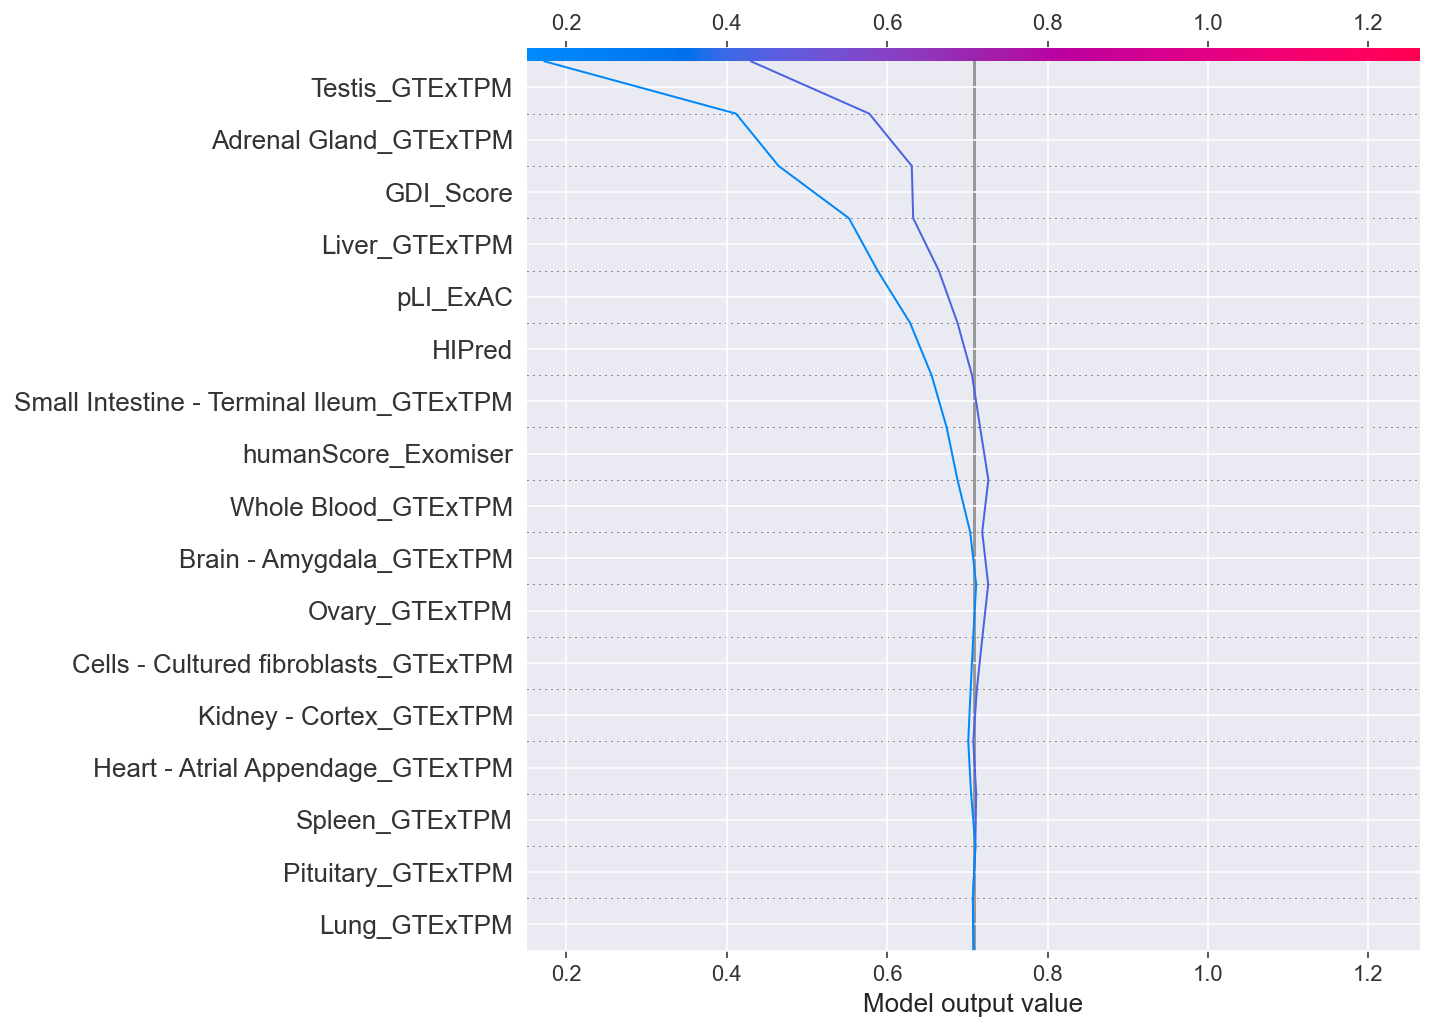

In [52]:
T = X[(y_pred <= 0.5)]
T = T[(Y == 0.75)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [53]:
print(T)

     Cells - Cultured fibroblasts_GTExTPM  Heart - Atrial Appendage_GTExTPM  \
351                                   0.0                               0.0   
458                                   0.0                               0.0   

     Adrenal Gland_GTExTPM  Testis_GTExTPM  humanScore_Exomiser  pLI_ExAC  \
351                    0.0        0.013263                  0.0  0.659178   
458                    0.0        0.000000                  0.0  0.472808   

      GDI_Score  Lung_GTExTPM    HIPred  Whole Blood_GTExTPM  Ovary_GTExTPM  \
351  638.823660           0.0  0.317764             0.327527            0.0   
458  850.115691           0.0  0.288966             0.000000            0.0   

     Spleen_GTExTPM  Kidney - Cortex_GTExTPM  Pituitary_GTExTPM  \
351        0.056548                      0.0                0.0   
458        0.000000                      0.0                0.0   

     Small Intestine - Terminal Ileum_GTExTPM  Liver_GTExTPM  \
351                       

In [54]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

X.iloc[[351, 458]]

Cells - Cultured fibroblasts_GTExTPM  \
Gene                                           
GPR42                                    0.0   
MIR33A                                   0.0   

        Heart - Atrial Appendage_GTExTPM  Adrenal Gland_GTExTPM  \
Gene                                                              
GPR42                                0.0                    0.0   
MIR33A                               0.0                    0.0   

        Testis_GTExTPM  humanScore_Exomiser  pLI_ExAC   GDI_Score  \
Gene                                                                
GPR42         0.013263                  0.0  0.659178  638.823660   
MIR33A        0.000000                  0.0  0.472808  850.115691   

        Lung_GTExTPM    HIPred  Whole Blood_GTExTPM  Ovary_GTExTPM  \
Gene                                                                 
GPR42            0.0  0.317764             0.327527            0.0   
MIR33A           0.0  0.288966             0.000000            0.0   

        Spleen_GTExTPM  Kidney - Cortex_GTExTPM  Pituitary_GTExTPM  \
Gene                                                                 
GPR42         0.056548                      0.0                0.0   
MIR33A        0.000000                      0.0                0.0   

        Small Intestine - Terminal Ileum_GTExTPM  Liver_GTExTPM  \
Gene                                                              
GPR42                                   0.049364            0.0   
MIR33A                                  0.000000            0.0   

        Brain - Amygdala_GTExTPM  
Gene                              
GPR42                        0.0  
MIR33A                       0.0

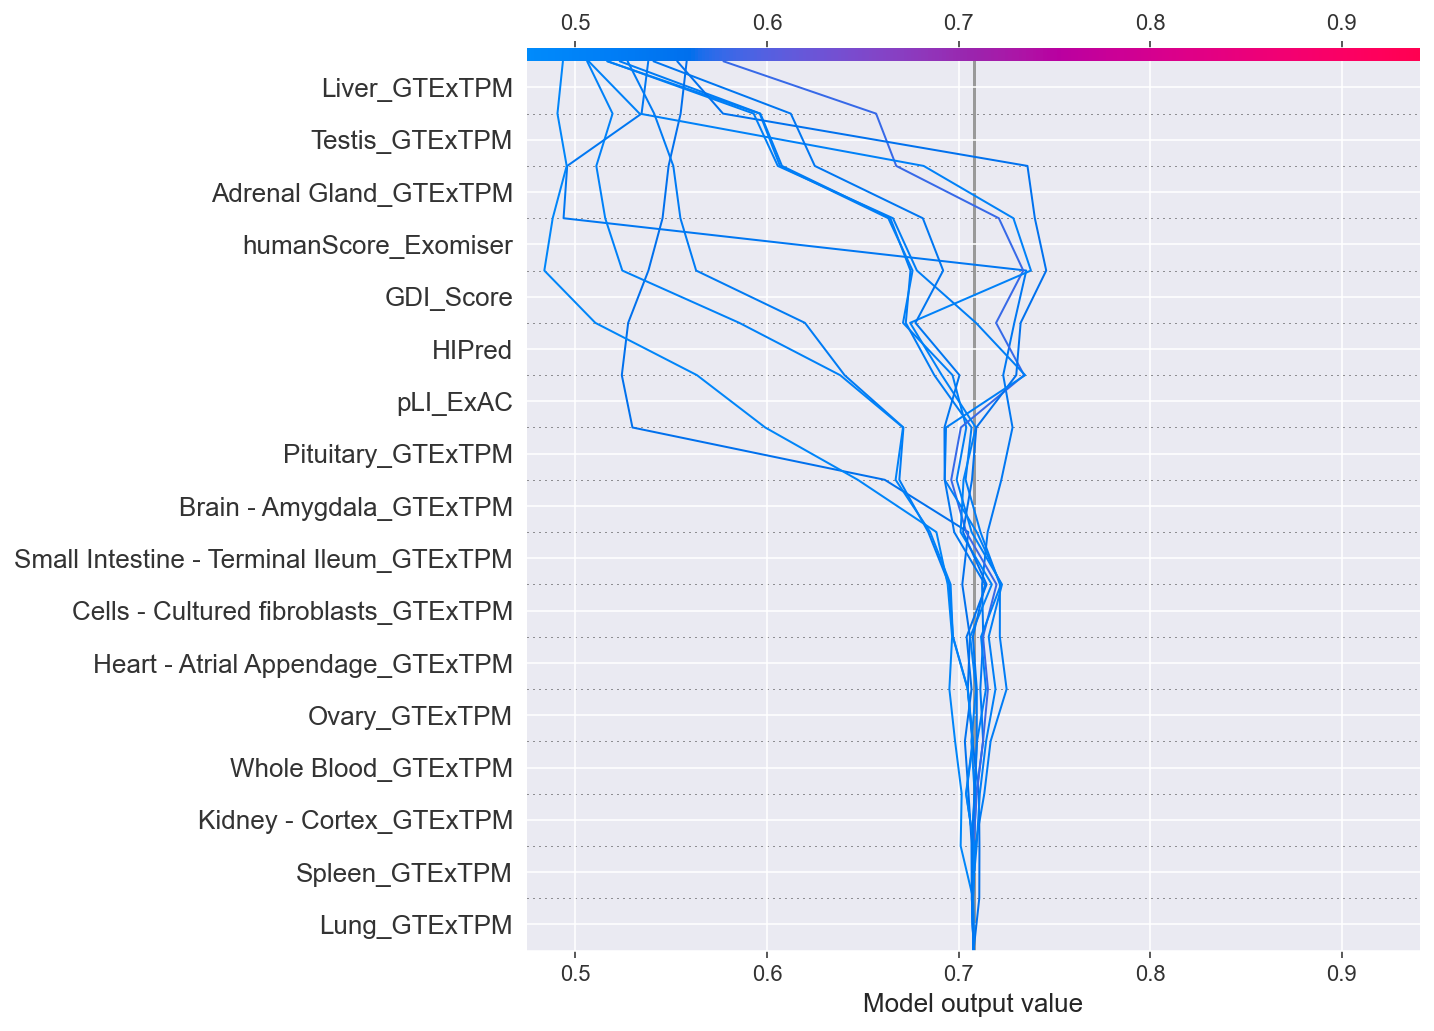

In [55]:
y_pred = XGB.predict(X)

T = X[(y_pred >= 0.5) & (y_pred <= 0.6)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [18]:
predictions = list(XGB.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

output

df_b = data[["label_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c

Gene  XGB_Score  label_encoded
0      ABCA1   0.903607           1.00
1     ABCA12   0.653414           0.75
2      ABCA2   0.696213           0.75
3      ABCA3   0.765888           0.75
4      ABCA7   0.739877           0.75
..       ...        ...            ...
799    ZFP91   0.685715           0.75
800  ZFYVE28   0.761151           0.75
801    ZNF32   0.734938           0.75
802   ZNF664   0.733603           0.75
803   ZNF781   0.755808           0.75

[804 rows x 3 columns]

## Unknown Gene Prediction

In [19]:
dataset_unknown = pd.read_csv("lipids_predicted_alltypes.txt", sep=",")
dataset_unknown = dataset_unknown[~dataset_unknown.loc[:,'Gene'].isin(df_c['Gene'])]
df2 = dataset_unknown[
    [
      'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]

df2.shape

(52981, 17)

In [20]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

Iteration: 0


KeyboardInterrupt: 

In [ ]:
X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)
X2.shape

In [64]:
model = XGB
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

In [65]:
df_total.nlargest(10, "XGB_Score", keep="last")

Gene  logpval_gwascatalog  \
9748      CPT2            17.698970   
18477      KHK             7.000000   
16140     HADH            11.301030   
4115     ACAD9                  NaN   
15481   GLYCTK             9.301030   
47552     SORD             5.698970   
4114     ACAD8             7.221849   
46236  SLC29A3             7.698970   
4562       AGL             6.397940   
25969    PLIN1            11.045757   

                                               gwastrait  \
9748                                   Metabolite levels   
18477                Self-reported risk-taking behaviour   
16140                                         Hair color   
4115                                                 NaN   
15481                          Total testosterone levels   
47552           Alzheimer's disease in APOE e4+ carriers   
4114   Obesity-related traits, Obesity-related traits...   
46236  Systemic lupus erythematosus, Diisocyanate-ind...   
4562   Pulmonary function decline, Carotid intima med...   
25969  Waist-to-hip ratio adjusted for BMI, HDL chole...   

       Adipose - Subcutaneous_GTExTPM  Adipose - Visceral (Omentum)_GTExTPM  \
9748                          9.31884                               7.79499   
18477                         3.65354                               3.09637   
16140                        48.48460                              50.85610   
4115                         26.89630                              24.87410   
15481                        14.08280                              15.08890   
47552                         2.25736                               2.09898   
4114                         19.37270                              17.56260   
46236                         7.41433                               6.13122   
4562                         11.81070                               7.50661   
25969                       970.21500                             542.53800   

       Adrenal Gland_GTExTPM  Artery - Aorta_GTExTPM  \
9748                19.78130                 6.21717   
18477                6.62790                 5.36107   
16140               31.54400                40.73000   
4115                28.14650                27.04060   
15481                9.29844                 5.68484   
47552               13.08310                 3.98714   
4114                23.76700                18.28890   
46236                3.38742                 6.05204   
4562                 8.31823                12.21730   
25969                2.11043                 3.22444   

       Artery - Coronary_GTExTPM  Artery - Tibial_GTExTPM  Bladder_GTExTPM  \
9748                     8.39610                  7.22357         11.95930   
18477                    4.50676                  4.85107          3.26127   
16140                   32.19850                 45.62760         29.65600   
4115                    26.91230                 26.34930         26.69690   
15481                    7.81951                  3.83173          9.06708   
47552                    3.14645                  2.45029          4.60713   
4114                    18.84340                 16.28370         21.63960   
46236                    6.42649                  5.19343         10.85830   
4562                    14.62470                 15.83290         16.28030   
25969                   30.27430                  1.43995          4.99843   

       ...  H3k79me2_count  SignalValue_H3k79me2_median  H3k9ac_count  \
9748   ...            22.0                      5.84735          19.0   
18477  ...             NaN                          NaN          15.0   
16140  ...           111.0                      3.76167          18.0   
4115   ...           165.0                      6.58270          26.0   
15481  ...            39.0                      7.14453          14.0   
47552  ...            87.0                      5.98427          15.0   
4114   ...            22.0                      4.27235       

In [66]:
df_file = df_total[["Gene", "XGB_Score"]]
df_file = df_file.nlargest(52981, "XGB_Score", keep="last")

### Model Prediction Distribution:

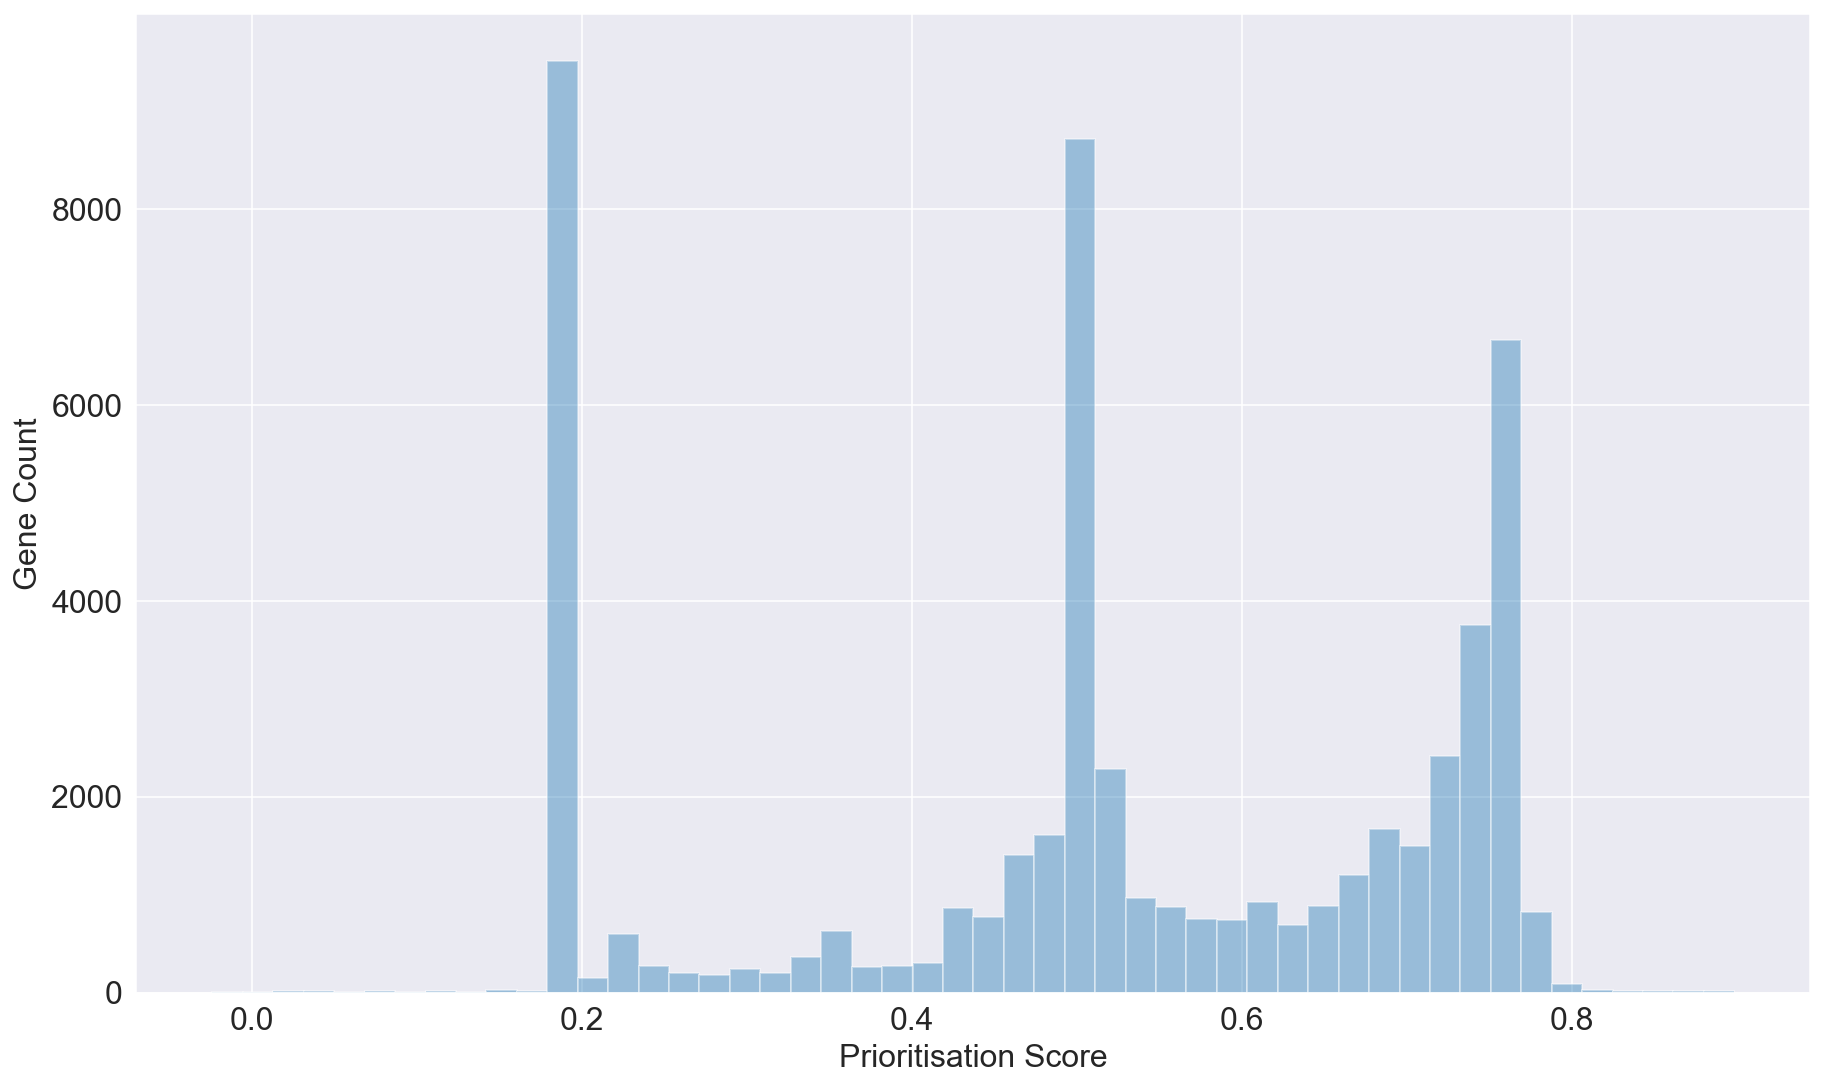

In [67]:
ax = sns.distplot(df_total["XGB_Score"], kde=False, norm_hist=False)
ax.set_xlabel("Prioritisation Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

### SHAP Feature Importance Visualization:

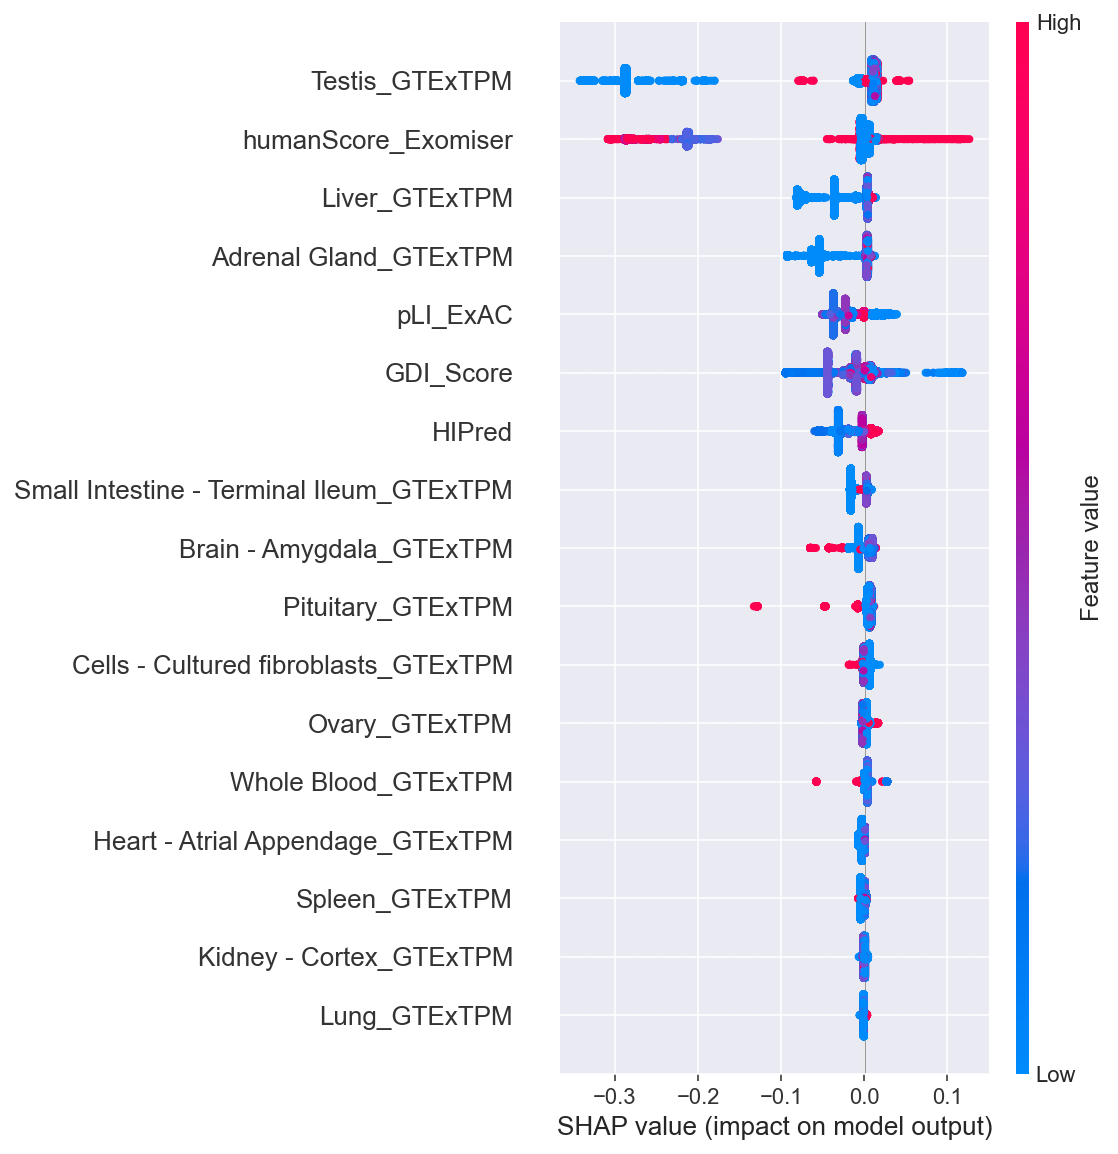

In [68]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)

In [24]:
dataset_unknown = pd.read_csv("lipids_predicted_alltypes.txt", sep=",")
sex_biased = pd.read_csv("selected_sexbiased.csv", sep=",")
dataset_unknown=pd.merge(sex_biased,dataset_unknown, how='left')
df2 = dataset_unknown[
    [
      'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]

imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)

model = XGB
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


Text(0.5, 0, 'XGB Feature Importance (weight score)')

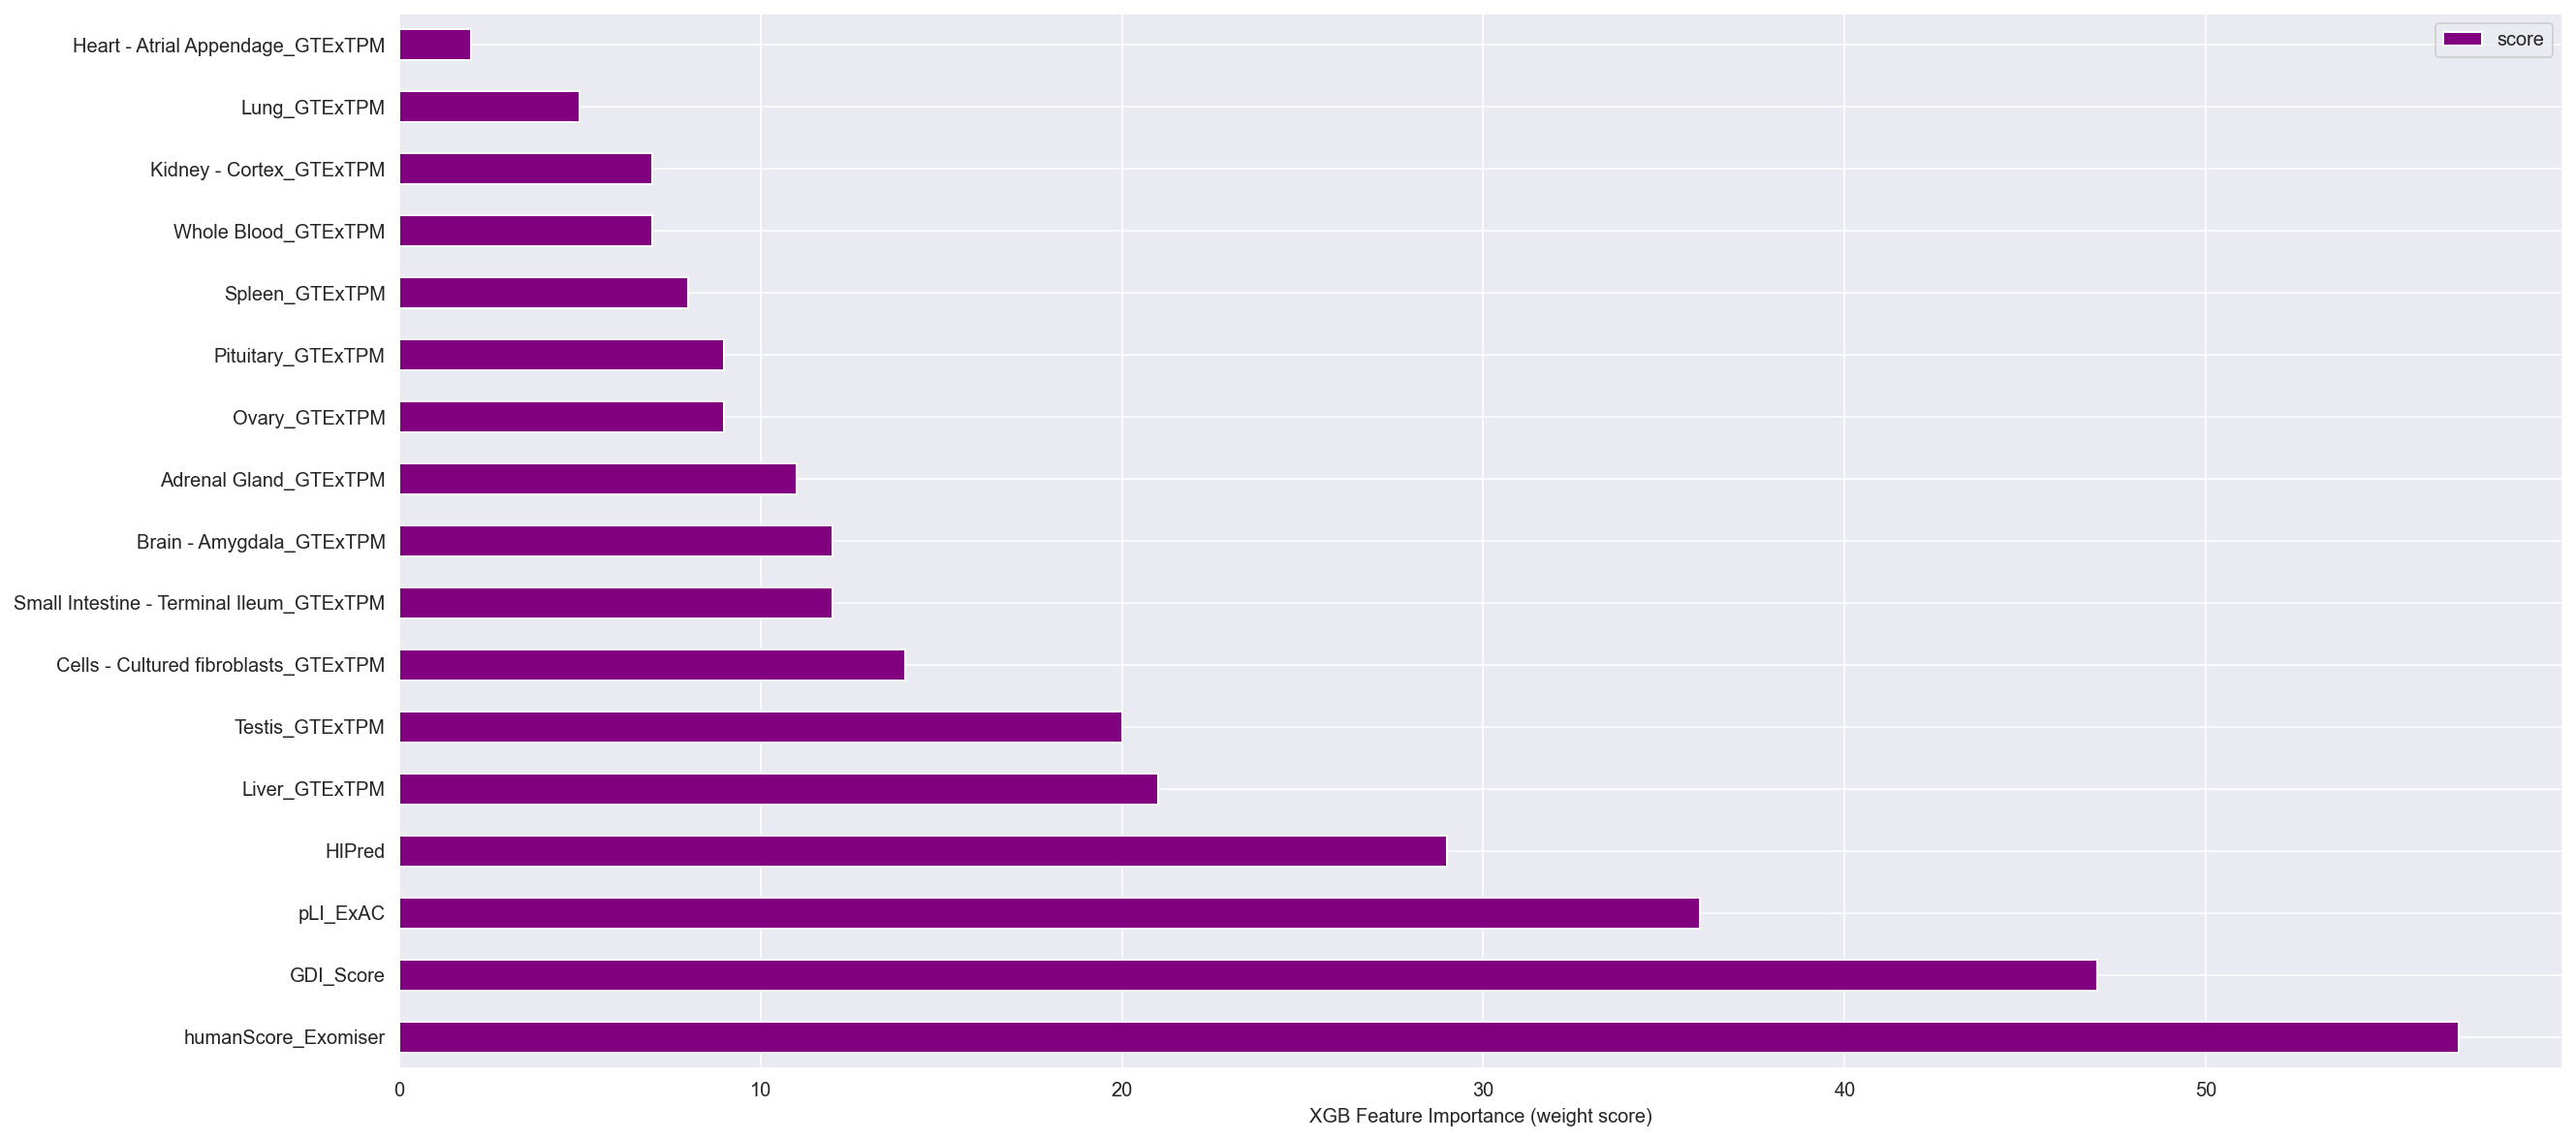

In [47]:
feature_important = model.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score")
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10), color='purple')
plt.xlabel("XGB Feature Importance (weight score)")

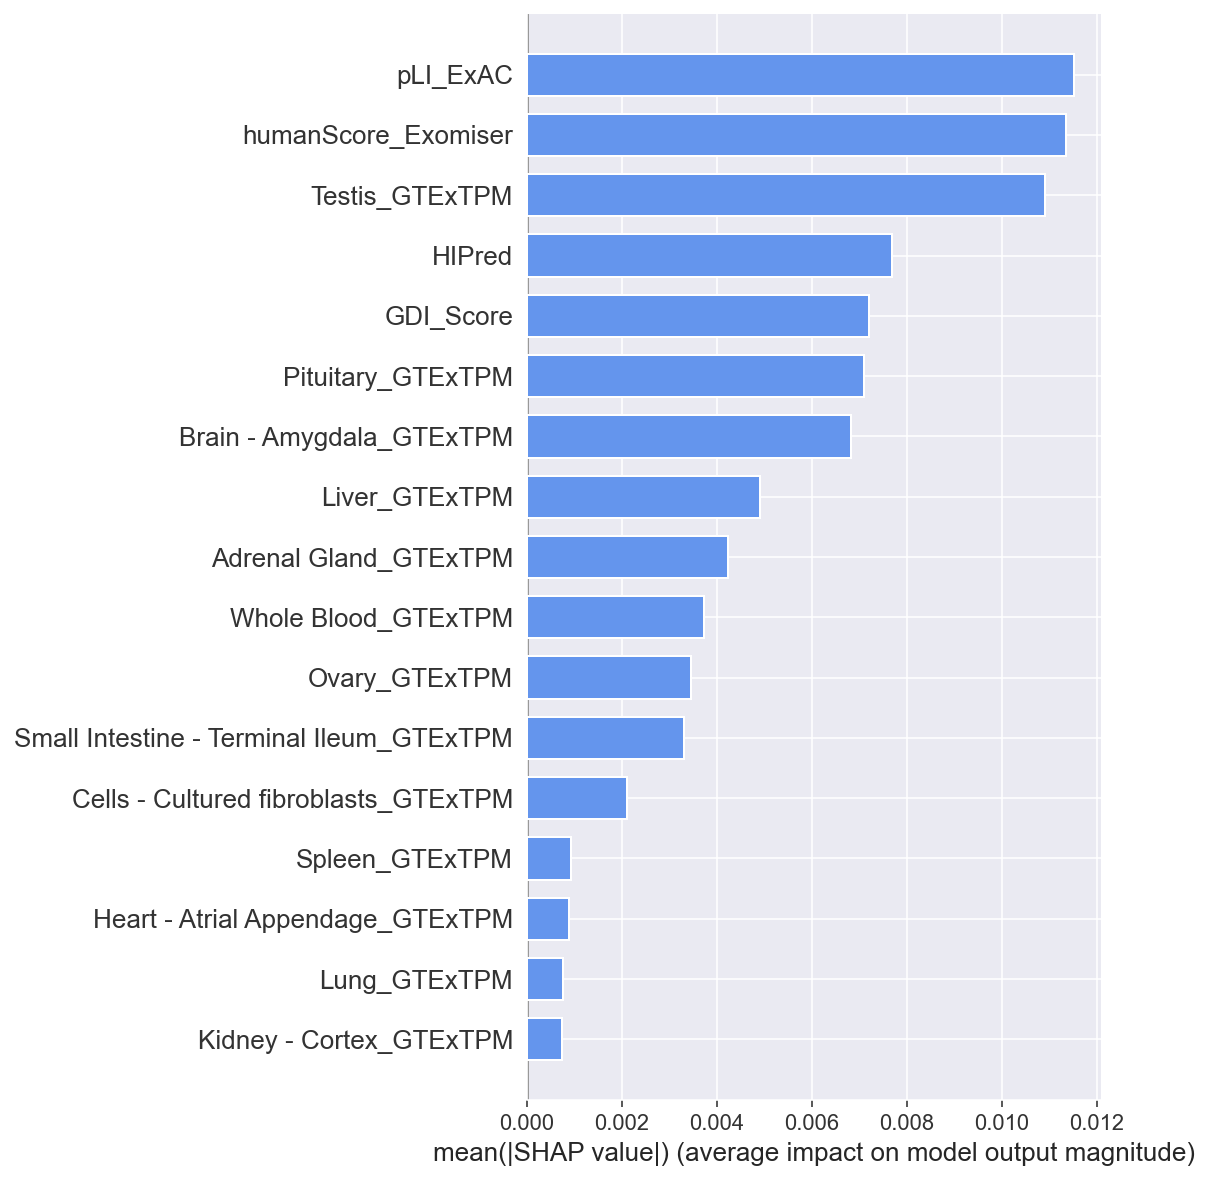

In [44]:
shap.summary_plot(shap_values, X2, plot_type="bar", color='cornflowerblue')

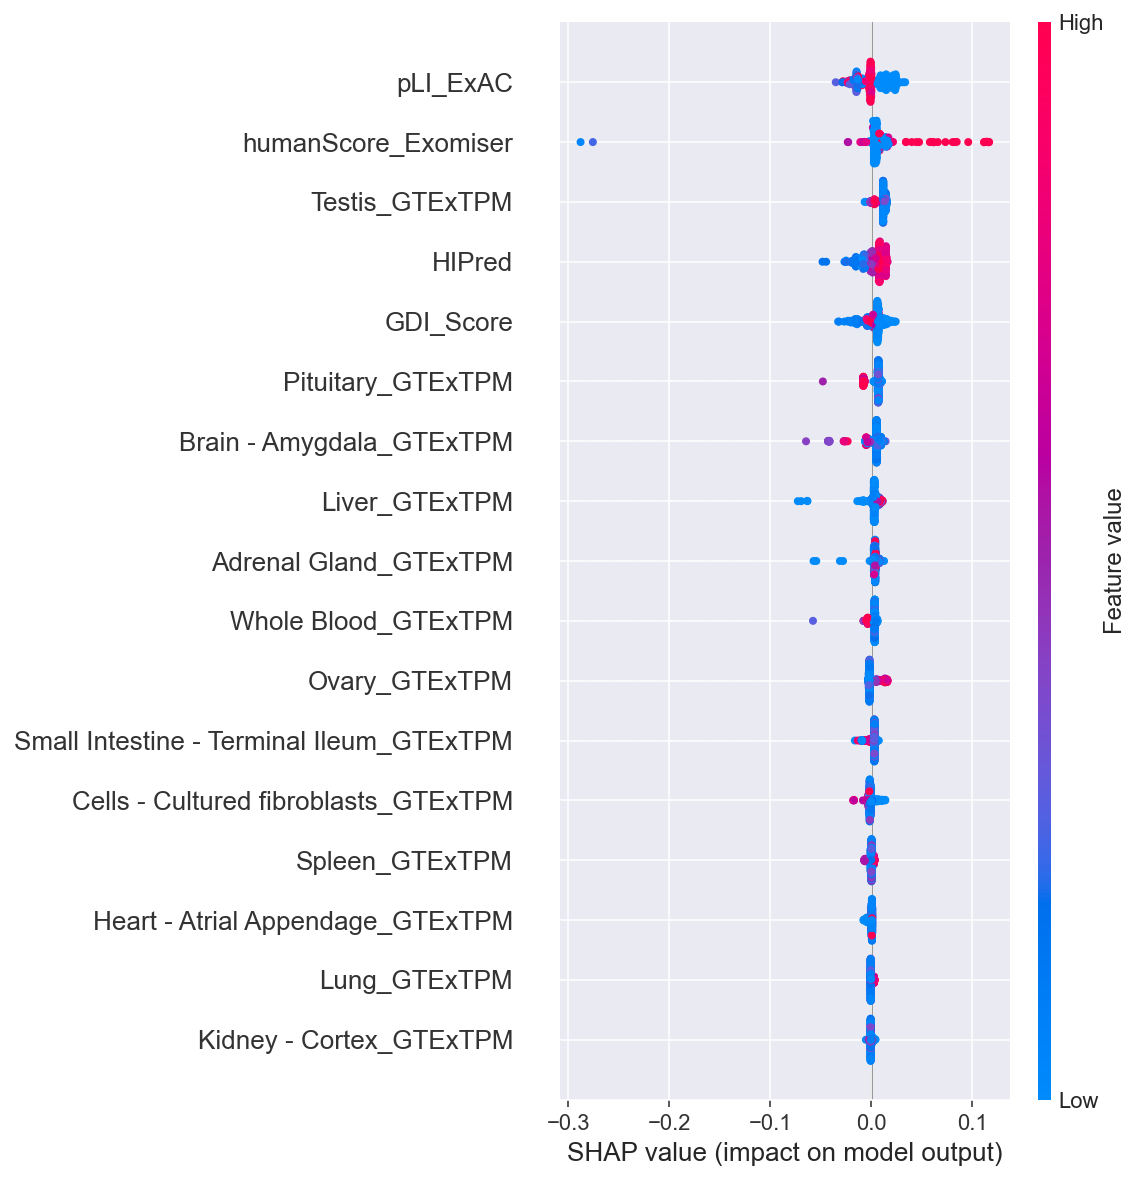

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)

In [69]:
dataset_unknown = pd.read_csv("lipids_predicted_proteincoding.txt", sep=",")
df2 = dataset_unknown[
    [
        'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]

imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)

model = XGB
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [70]:
df_total.nlargest(10, "XGB_Score", keep="last")

Gene  logpval_gwascatalog  \
1301      APOB           196.221849   
12204    PCSK9           562.522879   
1065   ANGPTL3                  NaN   
31       ABCA1           286.000000   
9173      LDLR           261.397940   
4156      CPT2            17.698970   
1300     APOA5           537.000000   
8620       KHK             7.000000   
7391      HADH            11.301030   
9178   LDLRAP1            73.154902   

                                               gwastrait  \
1301   Triglyceride levels, LDL cholesterol levels x ...   
12204  Total cholesterol levels, LDL cholesterol leve...   
1065                                                 NaN   
31     Triglyceride levels, Triglyceride levels, HDL ...   
9173   LDL cholesterol levels x short total sleep tim...   
4156                                   Metabolite levels   
1300   Triglyceride levels, Low HDL-cholesterol level...   
8620                 Self-reported risk-taking behaviour   
7391                                          Hair color   
9178   Platelet count, Mean platelet volume, Mean pla...   

       Adipose - Subcutaneous_GTExTPM  Adipose - Visceral (Omentum)_GTExTPM  \
1301                         0.572114                              0.695954   
12204                        0.070863                              0.267342   
1065                         0.067716                              0.086417   
31                          31.213500                             26.554600   
9173                        19.329100                             38.482700   
4156                         9.318840                              7.794990   
1300                         0.018957                              0.000000   
8620                         3.653540                              3.096370   
7391                        48.484600                             50.856100   
9178                        13.371100                             12.547600   

       Adrenal Gland_GTExTPM  Artery - Aorta_GTExTPM  \
1301                0.037602                3.385240   
12204               0.133870                0.196964   
1065                0.060948                0.278560   
31                 54.650500               11.259100   
9173               91.777900               15.251500   
4156               19.781300                6.217170   
1300                0.000000                0.042083   
8620                6.627900                5.361070   
7391               31.544000               40.730000   
9178               18.349700               34.642400   

       Artery - Coronary_GTExTPM  Artery - Tibial_GTExTPM  Bladder_GTExTPM  \
1301                    1.089510                 2.217180         0.176829   
12204                   0.083579                 0.101842         0.149421   
1065                    0.155823                 0.186032         0.154236   
31                     17.675200                11.807400        25.490000   
9173                   19.591300                18.058100        15.464300   
4156                    8.396100                 7.223570        11.959300   
1300                    0.035221                 0.040272         0.017143   
8620                    4.506760                 4.851070         3.261270   
7391                   32.198500                45.627600        29.656000   
9178                   20.799600                15.886500        12.628600   

       ...  H3k79me2_count  SignalValue_H3k79me2_median  H3k9ac_count  \
1301   ...             NaN                          NaN           NaN   
12204  ...             NaN                          NaN           NaN   
1065   ...             NaN                          NaN           NaN   
31     ...             NaN                          NaN         337.0   
9173   ...           149.0                      4.38551          55.0   
4156   ...            22.0                      5.84735          19.0   
1300   ...            15.0                      9.13232       

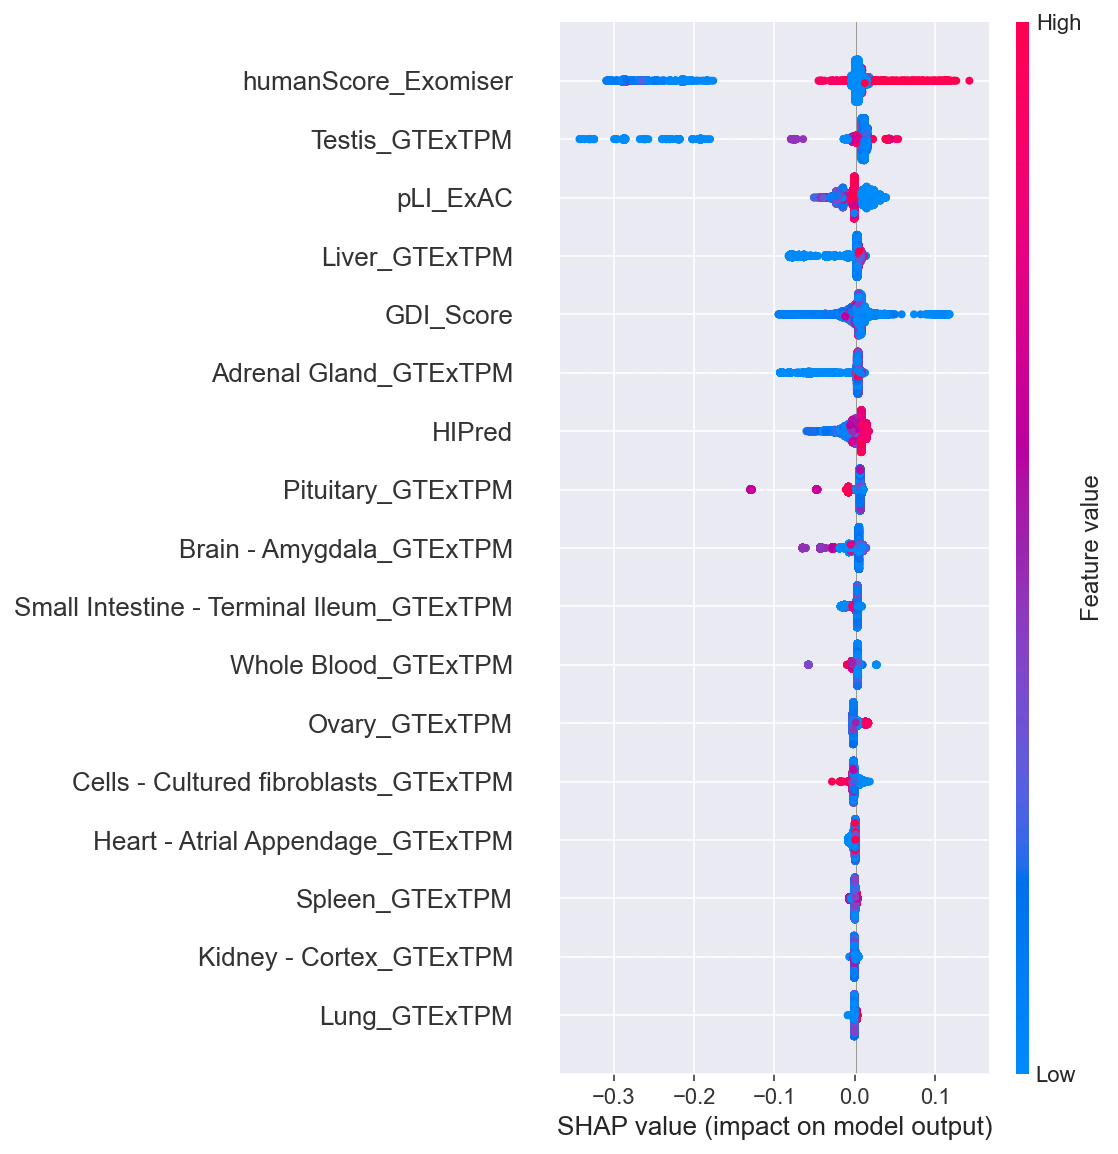

In [71]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)

In [72]:
expected_value = explainer.expected_value

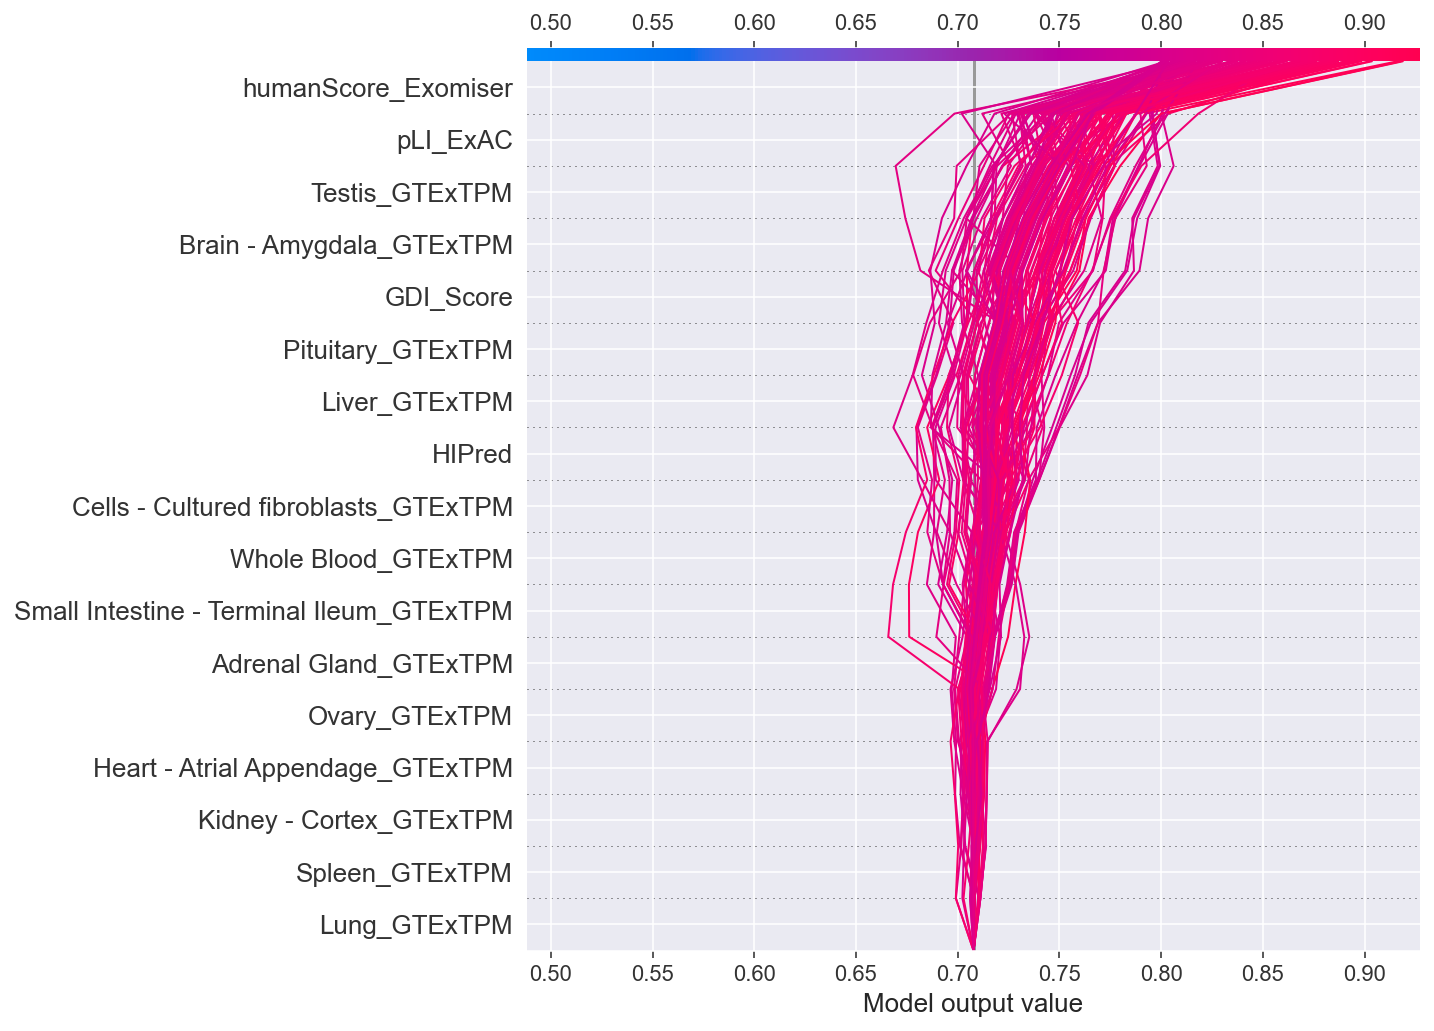

In [73]:
y_pred = model.predict(X2)

T = X2[(y_pred >= 0.8)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

In [188]:
L = [4985, 15636, 1065, 3576, 3574, 9196, 942, 12228, 3527, 8516]
X10 = X2.loc[L]

In [190]:
df10 = df_total.nlargest(10, "XGB_Score", keep="last")
df10 = df10[
    [
        'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]

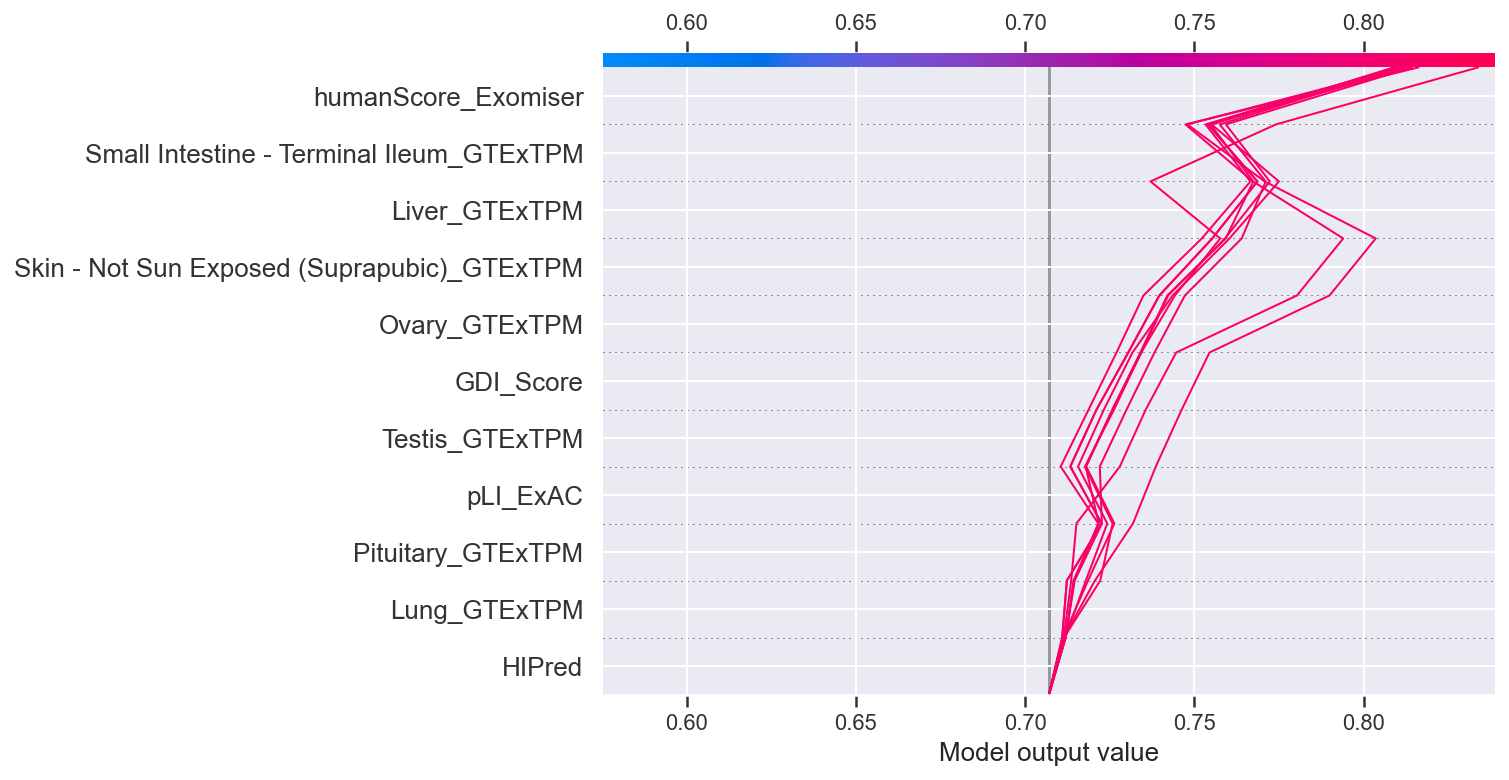

In [191]:
T = X10

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
r = shap.decision_plot(expected_value, sh, T, return_objects=True)

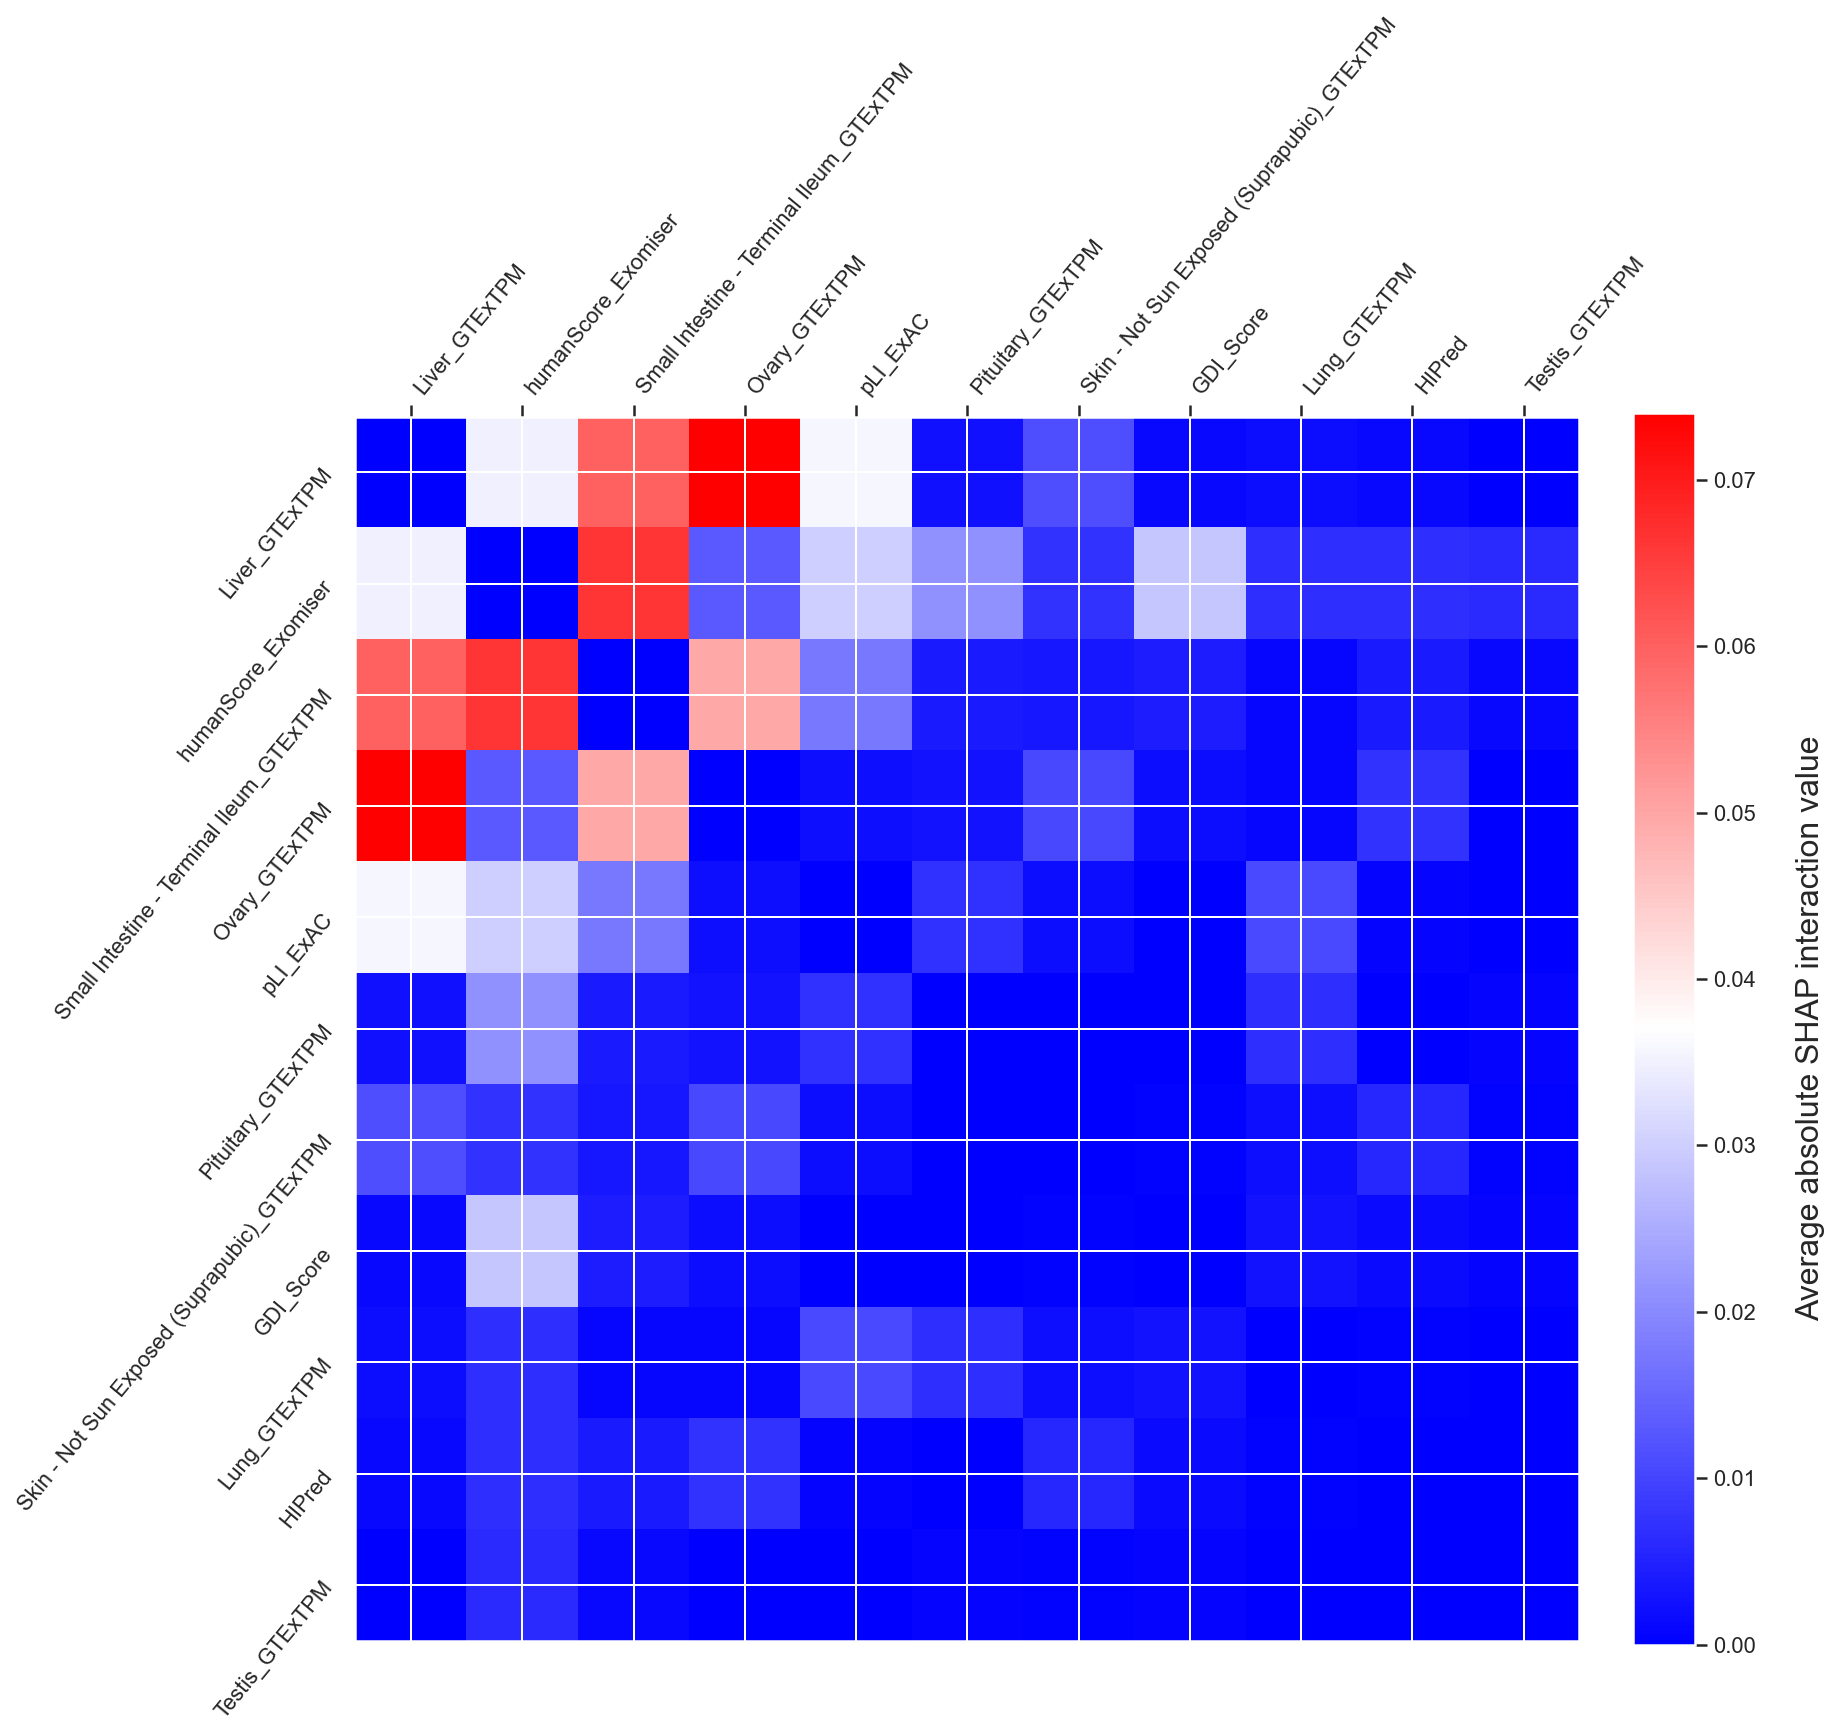

In [194]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X10)
X_interaction10 = pd.DataFrame(data=X10, columns=df10.columns)


tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.yticks(
    range(tmp2.shape[0]),
    X_interaction10.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    X_interaction10.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.show()

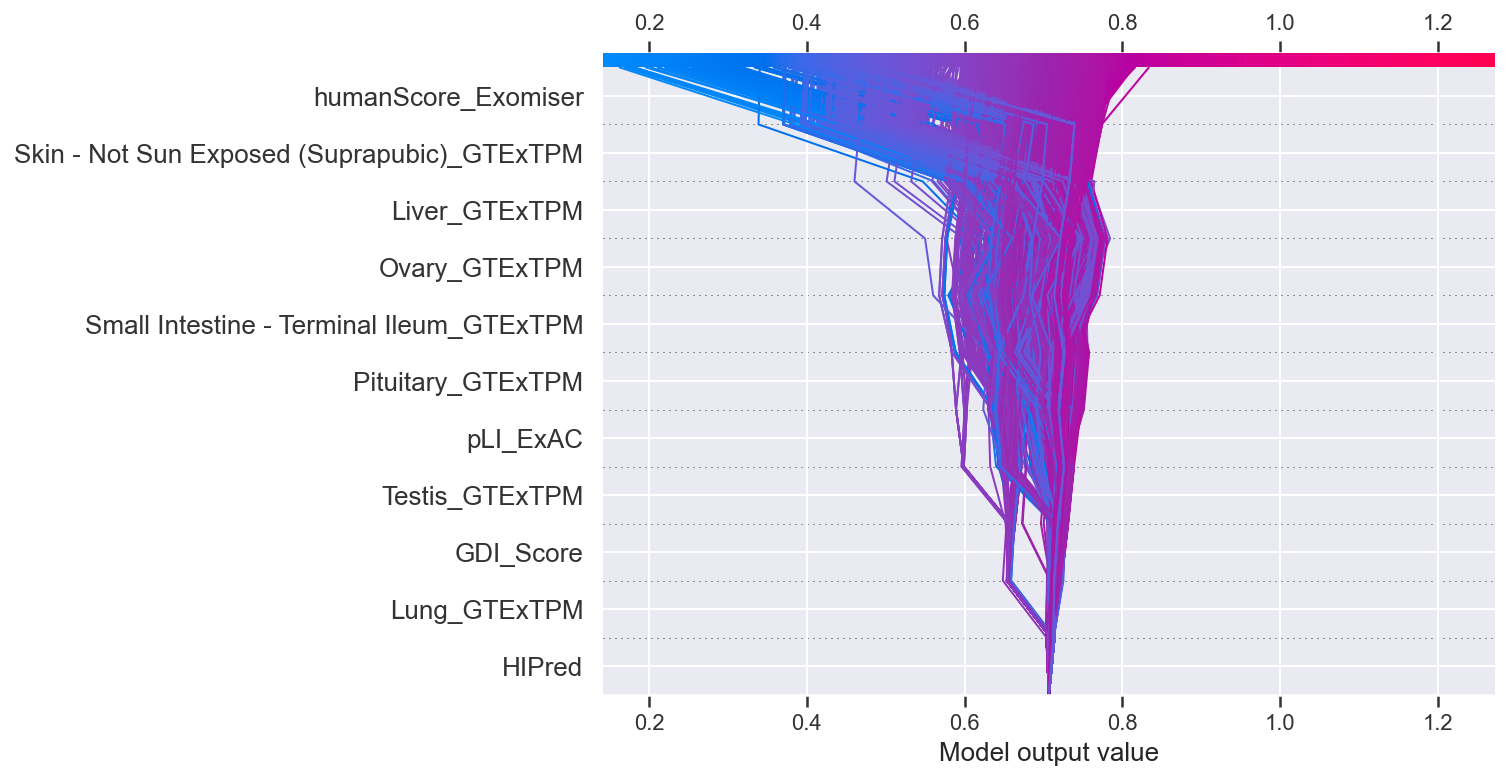

In [197]:
shap_values = explainer.shap_values(X2)
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values, X2, ignore_warnings=True)